In [169]:
import datetime 

import pandas as pd
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [170]:
# 시각화 테마 설정
sns.set_style('dark')
# sns.set_theme()
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

In [171]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [172]:
# 색상 코드 지정
green_code = ['#228B22', '#64ae64']
blue_code = ['#688BB3', '#8AB9CE']

In [173]:
# 일자별 중식계, 석식계를 예측하는 문제(정답 열이 2개)
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
holiday = pd.read_csv('data/holiday.csv')

# 기본 EDA

In [174]:
# shape
# 데이터 자체는 매우 작음
# 피쳐 생성을 어떻게 하느냐가 중요할 듯
print('train set : ', train.shape, ' test set : ', test.shape, ' submission : ', submission.shape)

train set :  (1205, 12)  test set :  (50, 10)  submission :  (50, 3)


In [175]:
# head
# 데이터 형태 파악
display(train.head(1))
display(test.head(1))
display(submission.head(1))

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


,일자,중식계,석식계
0,2021-01-27,0,0


In [176]:
# info - null 값, dtype, 메모리 사용량 등 파악악
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [177]:
# 결측치 확인 - 결측치 없음
train.isnull().sum()
# test.isnull().sum()

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
중식계               0
석식계               0
dtype: int64

In [178]:
# 중복값 확인
train.duplicated().sum()
# test.duplicated().sum()

0

In [179]:
# 기술통계
# 결측값, 고유값, 이상치, 중복 등 대략적으로 확인
# 휴가자수, 야근건수, 재택근무 min, max 차이가 꽤 큼 -> 시각화해서 확인
train.describe()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


In [180]:
# 겹치는 메뉴는 있음, 조·중식은 두개, 석식은 19개
train.describe(include = 'O')

,일자,요일,조식메뉴,중식메뉴,석식메뉴
count,1205,1205,1205,1205,1205
unique,1205,5,1204,1198,1168
top,2016-02-01,목,모닝롤/프렌치토스트 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 무채국 김...,쌀밥/잡곡밥 (쌀:국내산) 시금치된장국 훈제오리구이 실곤약무침 무쌈/양파절임 ...,*
freq,1,244,2,2,19


# 데이터 전처리

## 미사용 데이터 제외

In [181]:
# 조식메뉴 제외
train.drop('조식메뉴', axis = 1, inplace = True)
test.drop('조식메뉴', axis = 1, inplace = True)

## 새로운 피처 생성

In [182]:
# 미출근자수 피처 생성
train['미출근자수'] = train['본사휴가자수'] + train['본사출장자수'] + train['현본사소속재택근무자수']
test['미출근자수'] = test['본사휴가자수'] + test['본사출장자수'] + test['현본사소속재택근무자수']

In [183]:
# 본사근무자수 피처 생성
train['본사근무자수'] = train['본사정원수'] - train['미출근자수']
test['본사근무자수'] = test['본사정원수'] - test['미출근자수']

In [184]:
# 근무자 대비 식사 이용률
train['중식이용률'] = train['중식계']/train['본사근무자수'] * 100
train['석식이용률'] = train['석식계']/train['본사근무자수'] * 100
train['중식대비석식이용률'] = train['석식계']/train['중식계'] * 100

In [185]:
# 날짜데이터 형식 수정 및 파생변수 생성
train['일자'] = pd.to_datetime(train['일자'])
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['년월'] = train['일자'].astype(str).str[:7]

test['일자'] = pd.to_datetime(test['일자'])
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['년월'] = test['일자'].astype(str).str[:7]

/var/folders/h1/qk7q5tvs4f55rk_cpsw0m2880000gn/T/ipykernel_60492/1540700747.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

/var/folders/h1/qk7q5tvs4f55rk_cpsw0m2880000gn/T/ipykernel_60492/1540700747.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



## 이상치 처리

##### 석식메뉴 이상치

In [186]:
# 1. 석식메뉴 데이터 중 음식메뉴가 아닌 데이터 값
train[train['석식메뉴'].str.len() < 25]['석식메뉴'].value_counts()

    *                   19
                         4
    자기계발의날               3
    자기개발의날               3
     *                   2
      *                  2
    *  자기계발의날  *         2
    *  자기개발의날  *         2
      자기계발의날             1
      *자기계발의날*           1
      가정의날               1
   *  자기개발의날  *          1
 ＜자기 계발의 날＞              1
Name: 석식메뉴, dtype: int64

In [187]:
# 위 값을 모두 None 처리
train.loc[train['석식메뉴'].str.len() < 25, '석식메뉴'] = None

##### 석식계 이상치

In [188]:
# 2. 석식계가 0 인 데이터 : 43 개
print(train[train['석식계'] == 0].shape)

# 그 중 석식메뉴가 있으면서 0인 데이터
train[(train['석식계'] == 0) & pd.notna(train['석식메뉴'])][['일자', '석식메뉴', '석식계']]

(43, 21)


,일자,석식메뉴,석식계
410,2017-09-27,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 미니함박조림 계란말이 비름나물 포기김치 ...,0.0
502,2018-02-14,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 고추잡채*꽃빵 계란찜 오이무침 포기김치...,0.0


In [189]:
# 위 값도 정답값이 0이기 때문에 학습해도 오차만 늘릴 것...?
# 모두 None 처리
train.loc[(train['석식계'] == 0) & pd.notna(train['석식메뉴']), '석식메뉴'] = None

# EDA 시각화

#### 전체

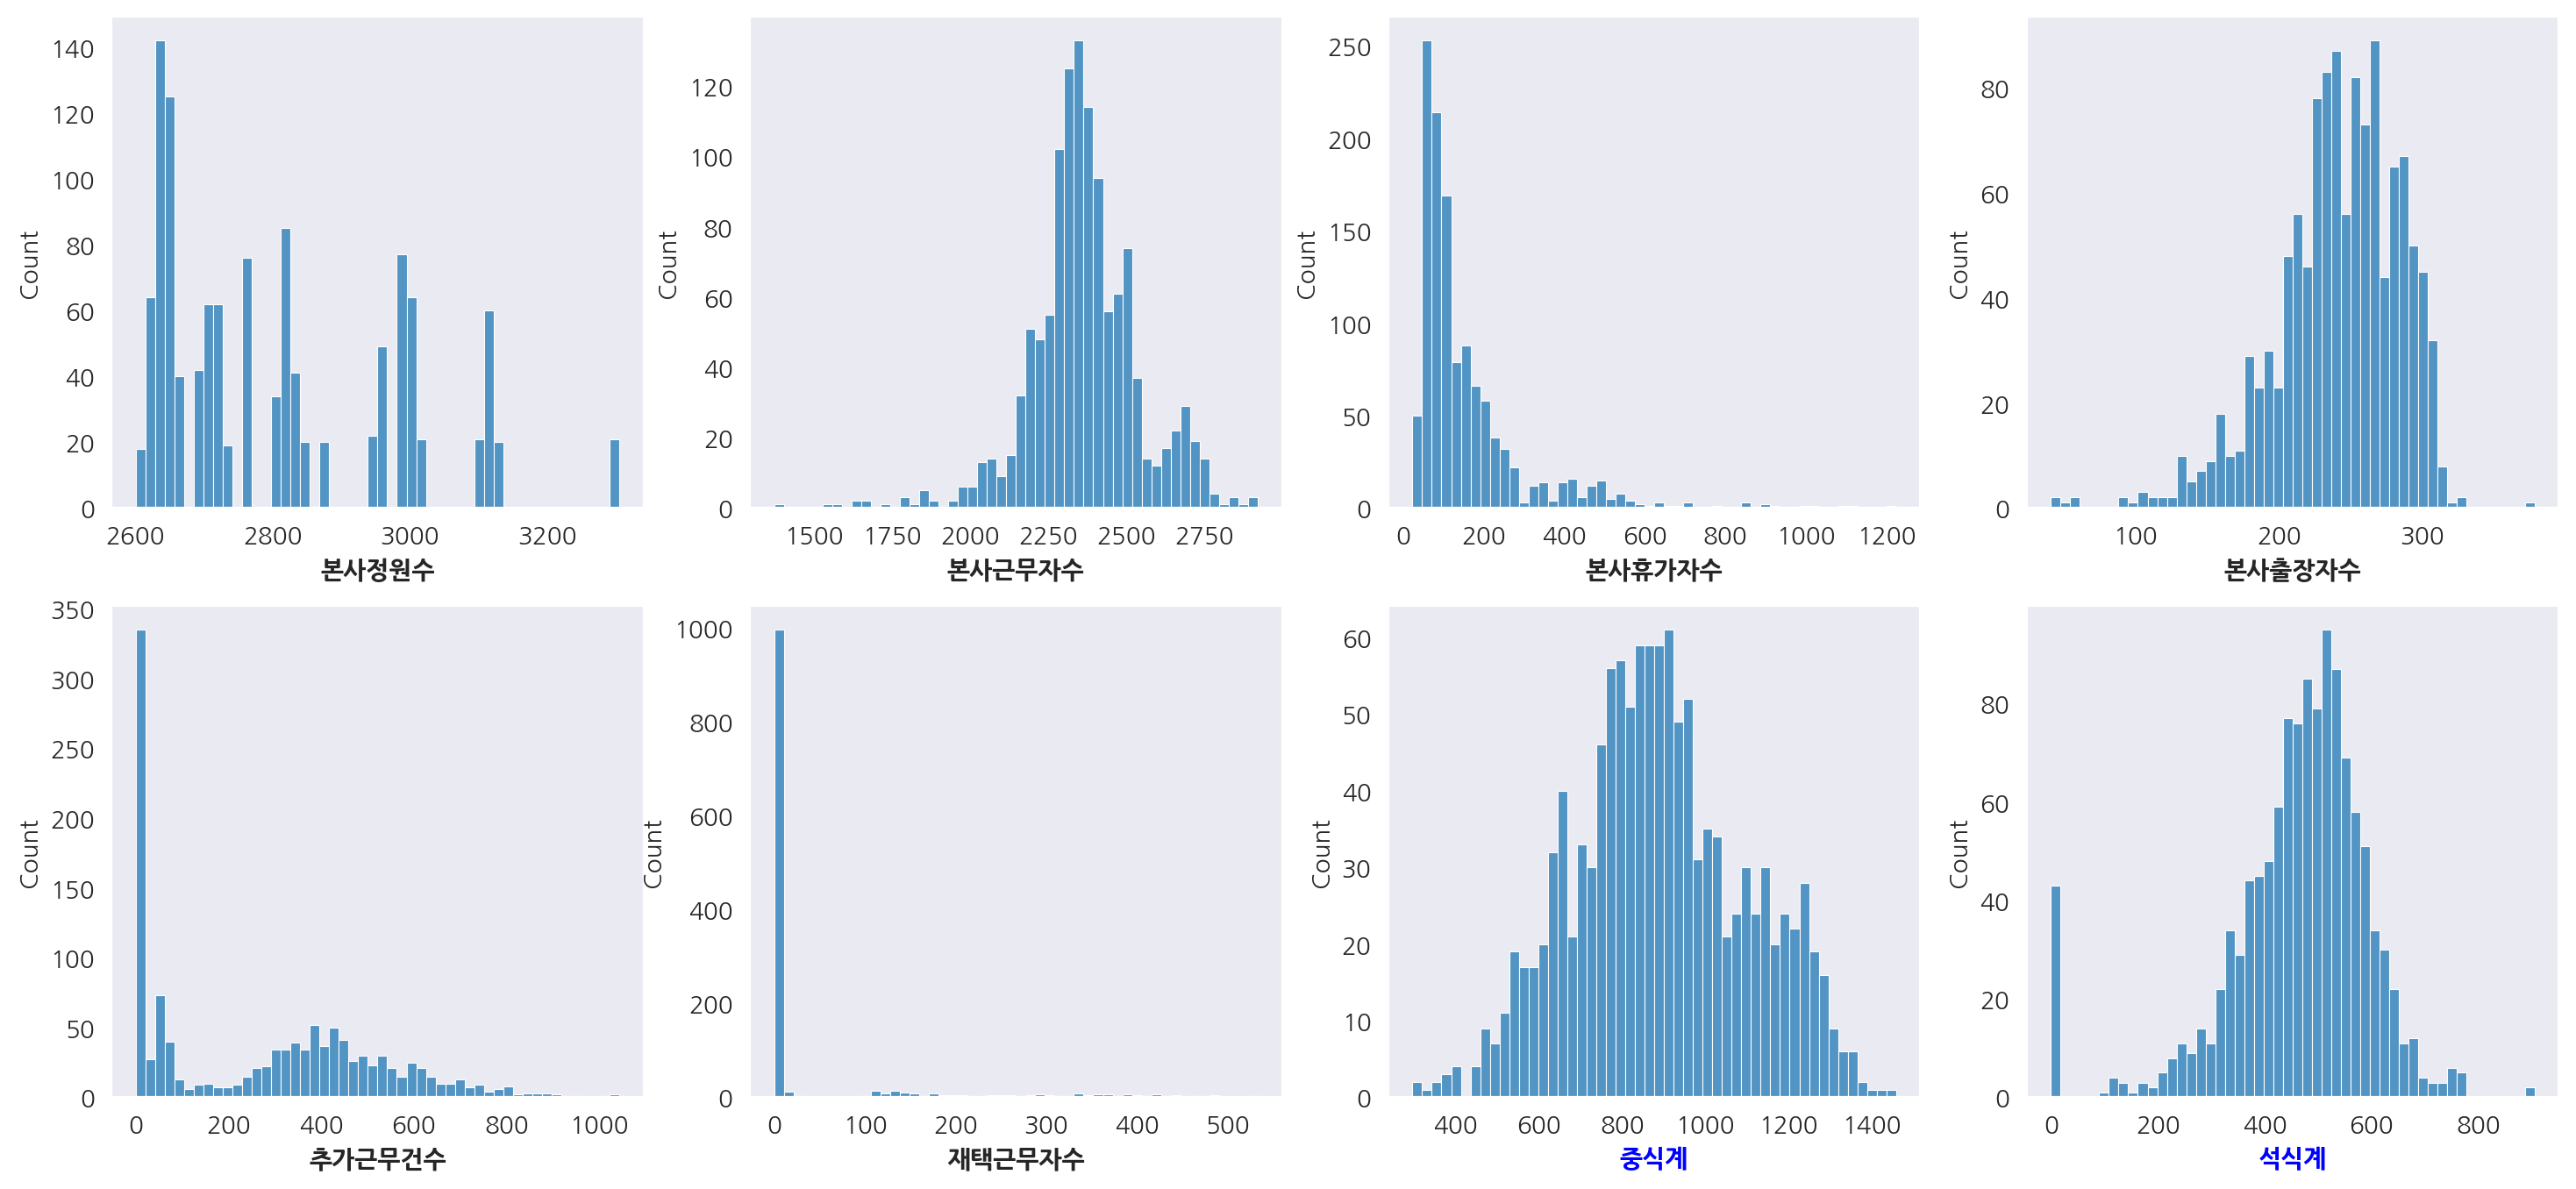

In [190]:
# 숫자데이터 분포 시각화
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
sns.histplot(train['본사정원수'], ax=axes[0, 0], bins=50)
sns.histplot(train['본사근무자수'], ax=axes[0, 1], bins=50)
sns.histplot(train['본사휴가자수'], ax=axes[0, 2], bins=50)
sns.histplot(train['본사출장자수'], ax=axes[0, 3], bins=50)
sns.histplot(train['본사시간외근무명령서승인건수'], ax=axes[1, 0], bins=50)
sns.histplot(train['현본사소속재택근무자수'], ax=axes[1, 1], bins=50)
sns.histplot(train['중식계'], ax=axes[1, 2], bins=50)
sns.histplot(train['석식계'], ax=axes[1, 3], bins=50)

axes[0,0].set_xlabel('본사정원수', fontweight='bold')
axes[0,1].set_xlabel('본사근무자수', fontweight='bold')
axes[0,2].set_xlabel('본사휴가자수', fontweight='bold')
axes[0,3].set_xlabel('본사출장자수', fontweight='bold')
axes[1,0].set_xlabel('추가근무건수', fontweight='bold')
axes[1,1].set_xlabel('재택근무자수', fontweight='bold')
axes[1,2].set_xlabel('중식계', fontweight='bold', color='blue')
axes[1,3].set_xlabel('석식계', fontweight='bold', color='blue')


plt.subplots_adjust(hspace=0.2, wspace=0.2) #간격

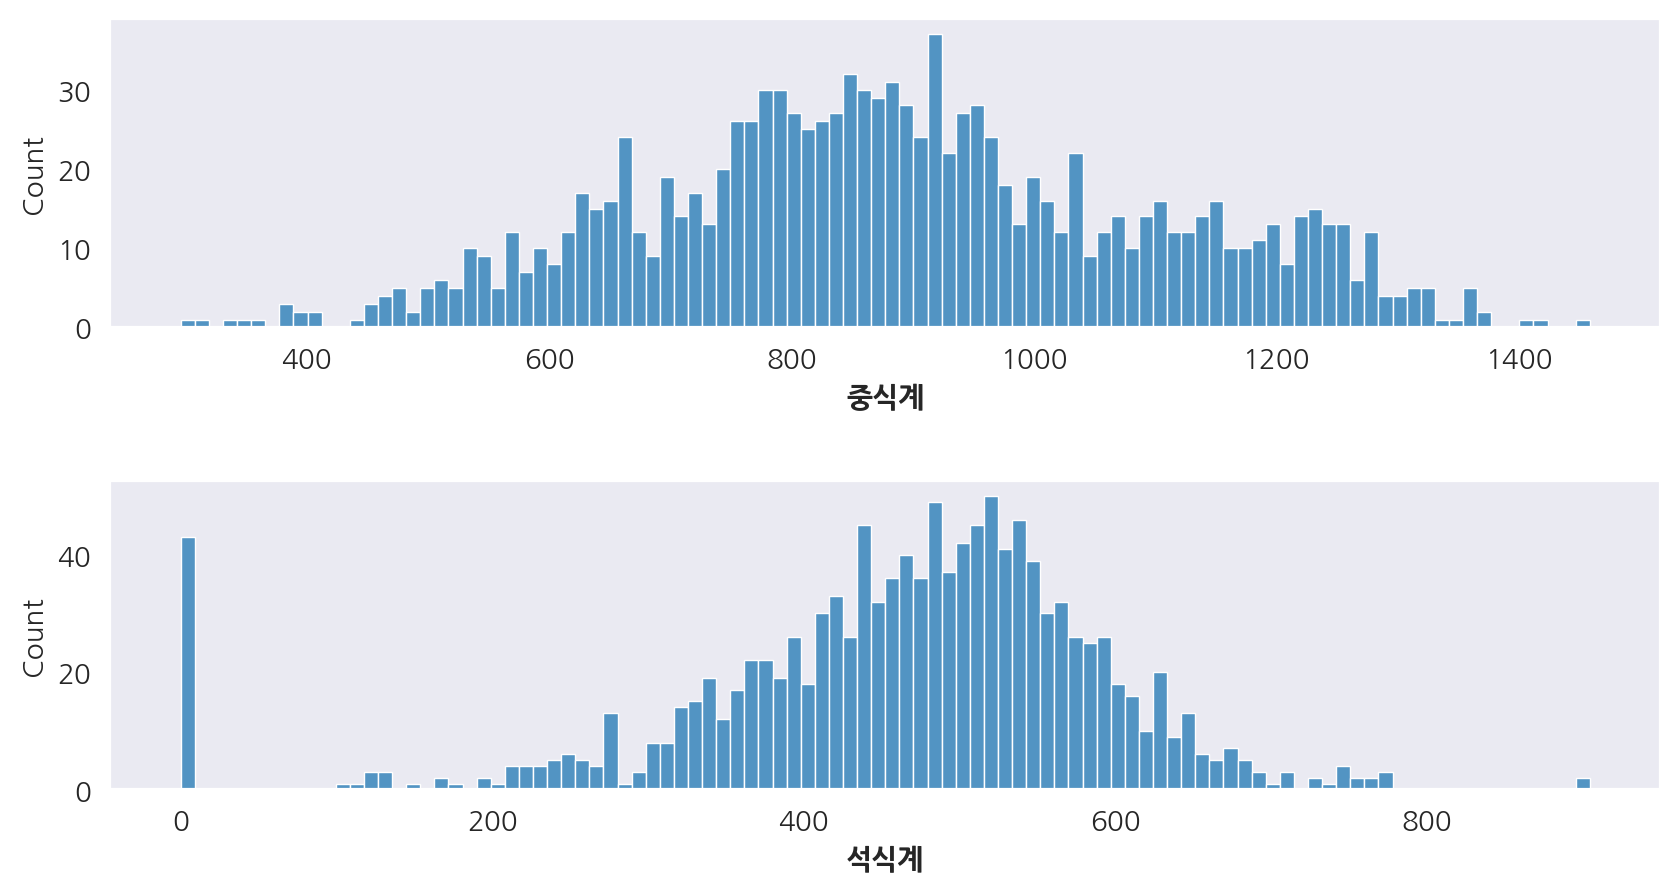

In [191]:
# 타겟데이터 분포 시각화
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
sns.histplot(train['중식계'], ax=axes[0], bins=100)
sns.histplot(train['석식계'], ax=axes[1], bins=100)

axes[0].set_xlabel('중식계', fontweight='bold')
axes[1].set_xlabel('석식계', fontweight='bold')
plt.subplots_adjust(hspace=0.5, wspace=0.5) #간격

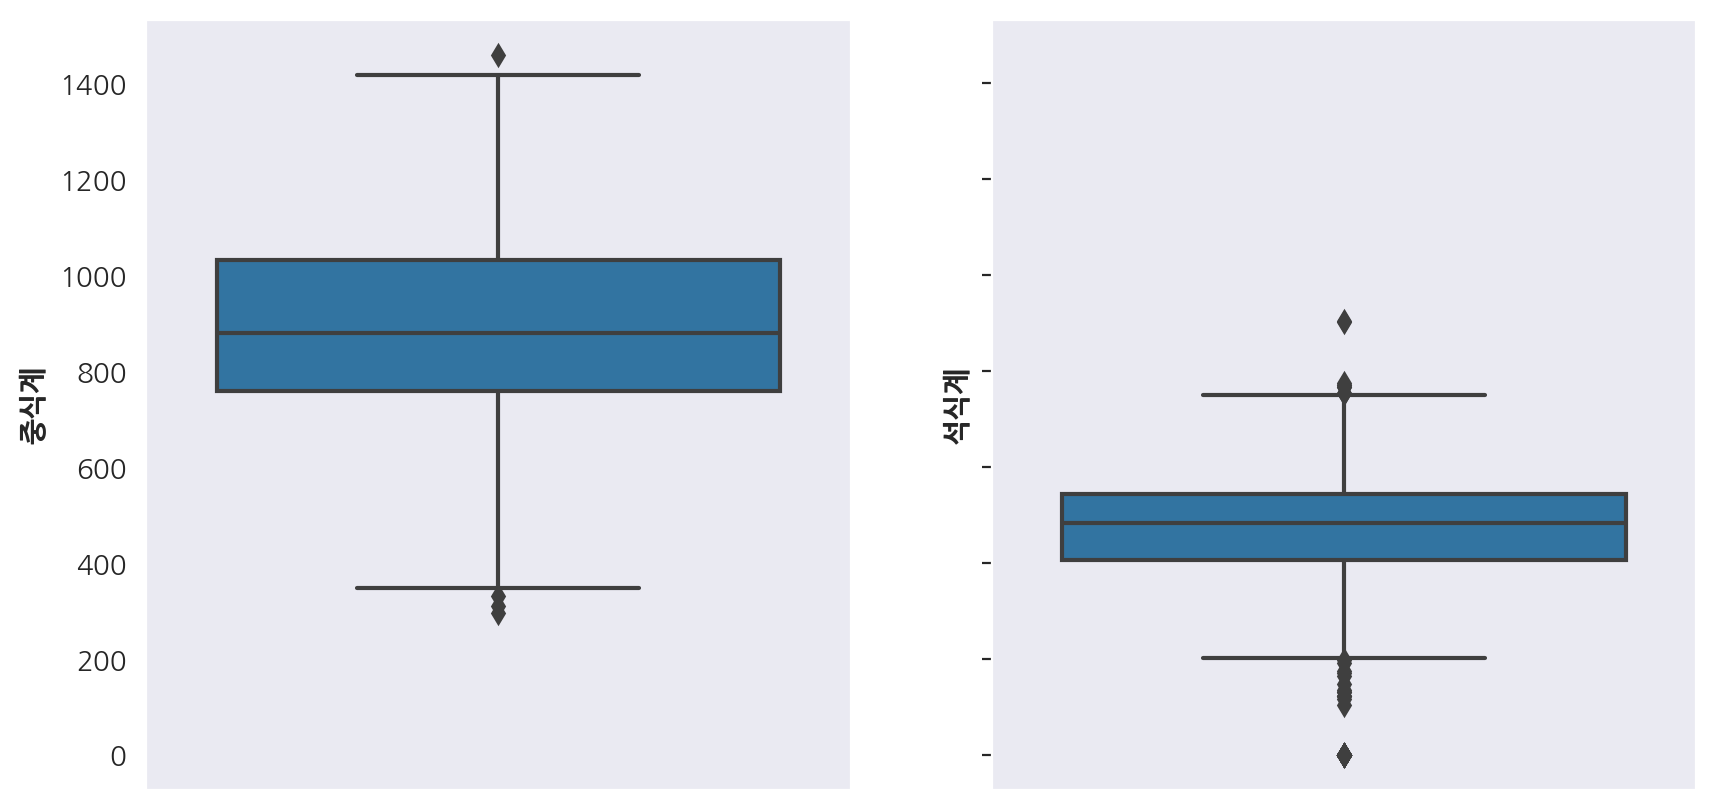

In [192]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

sns.boxplot(y=train['중식계'], data=train, ax=axes[0]);
sns.boxplot(y=train['석식계'], data=train, ax=axes[1]);

axes[0].set_ylabel('중식계', fontweight='bold')
axes[1].set_ylabel('석식계', fontweight='bold')

axes[1].yaxis.tick_left()

In [193]:
#전반적으로 중식계는 비교적 수치값이 일정하나, 석식이 Q1 이하인 경우가 많다
fig = make_subplots(rows=1, cols=2, shared_yaxes= True)
fig.add_trace(go.Box(y=train['중식계'], name='중식계'), row=1, col=1)
fig.add_trace(go.Box(y=train['석식계'], name='석식계'), row=1, col=2)
fig.update_layout(height=500, width=800)

In [194]:
def outlier(train, column):
    median = train[column].median()
    q1 = train[column].quantile(0.25)
    q3 = train[column].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr #1443.0
    lower_bound = q1 - 1.5 * iqr #347.0
    return train[(train[column] > upper_bound) | (train[column] < lower_bound)]

In [195]:
print(outlier(train, '중식계').shape)
print(outlier(train, '석식계').shape)

(4, 21)
(66, 21)


#### 일자 관련

In [196]:
#누락된 날짜 확인 
#모든 평일 데이터 만들기 
start_d = datetime.date(2016,2,1)
end_d = datetime.date(2021,4,9)

dates = pd.date_range(start=start_d, end=end_d, freq='B')
notnull = pd.DataFrame({'일자':dates})

In [197]:
all_week = pd.merge(notnull, train, how='left')
all_week['주'] = all_week['일자'].dt.week
all_week['년'] = all_week['일자'].dt.year
all_week.head(1)

/var/folders/h1/qk7q5tvs4f55rk_cpsw0m2880000gn/T/ipykernel_60492/786975460.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,...,미출근자수,본사근무자수,중식이용률,석식이용률,중식대비석식이용률,년,월,일,주,년월
0,2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,...,200.0,2401.0,43.273636,13.785923,31.857555,2016,2.0,1.0,5,2016-02


In [198]:
temp = pd.melt(all_week[all_week['년']==2018], id_vars=['주'], value_vars=['중식계', '석식계'], var_name='식계', value_name='평균값')
temp[temp['주']==39]

,주,식계,평균값
190,39,중식계,NaN
191,39,중식계,NaN
192,39,중식계,NaN
193,39,중식계,NaN
194,39,중식계,NaN
451,39,석식계,NaN
452,39,석식계,NaN
453,39,석식계,NaN
454,39,석식계,NaN
455,39,석식계,NaN


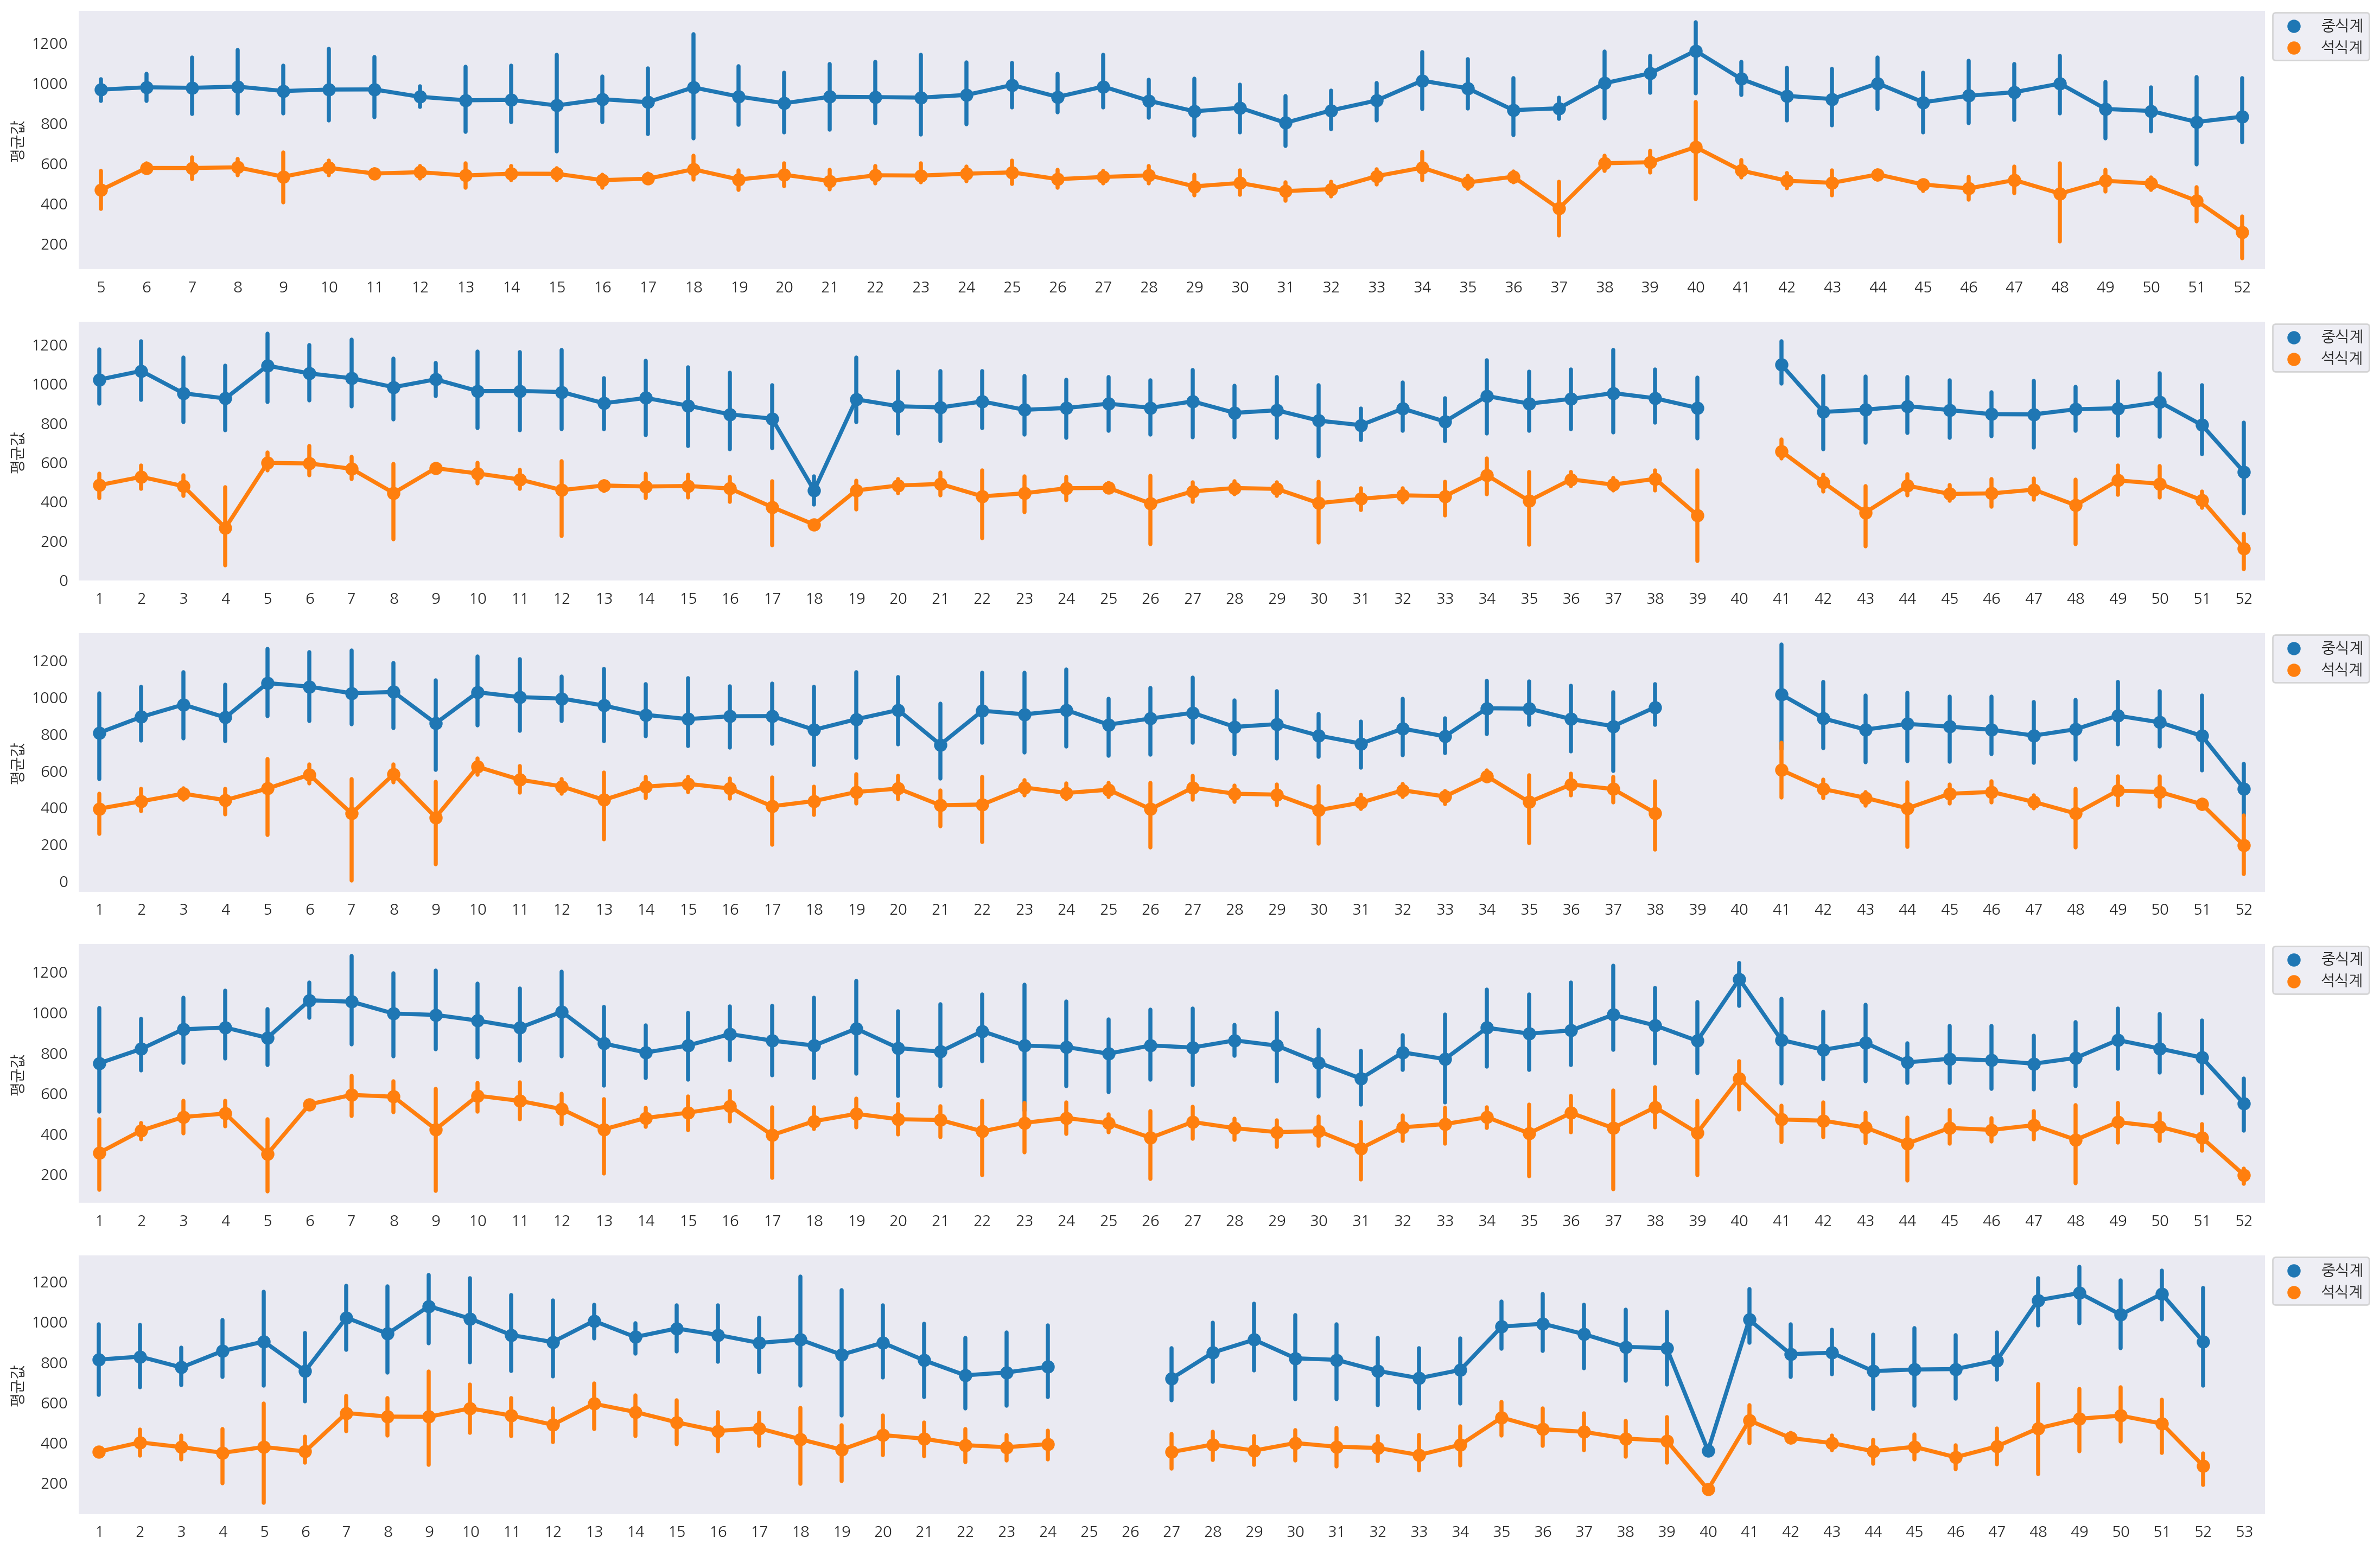

In [199]:
#전체 추이 
import warnings
warnings.filterwarnings('ignore', message='Mean of empty slice')
warnings.filterwarnings('ignore', message='All-NaN slice encountered')

year = [2016, 2017, 2018, 2019, 2020]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(26, 18))
for i,idx in enumerate(year):
    melted_train = pd.melt(all_week[all_week['년']==idx], id_vars=['주'], value_vars=['중식계', '석식계'], var_name='식계', value_name='평균값')
    sns.pointplot(data=melted_train, x='주', y='평균값', hue='식계', ax=axes[i])
    sns.despine()

axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.9))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.9))
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.9))
axes[3].legend(loc='center left', bbox_to_anchor=(1, 0.9))
axes[4].legend(loc='center left', bbox_to_anchor=(1, 0.9))

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[3].set_xlabel('')
axes[4].set_xlabel('')

plt.subplots_adjust(hspace=0.2, wspace=0.5)

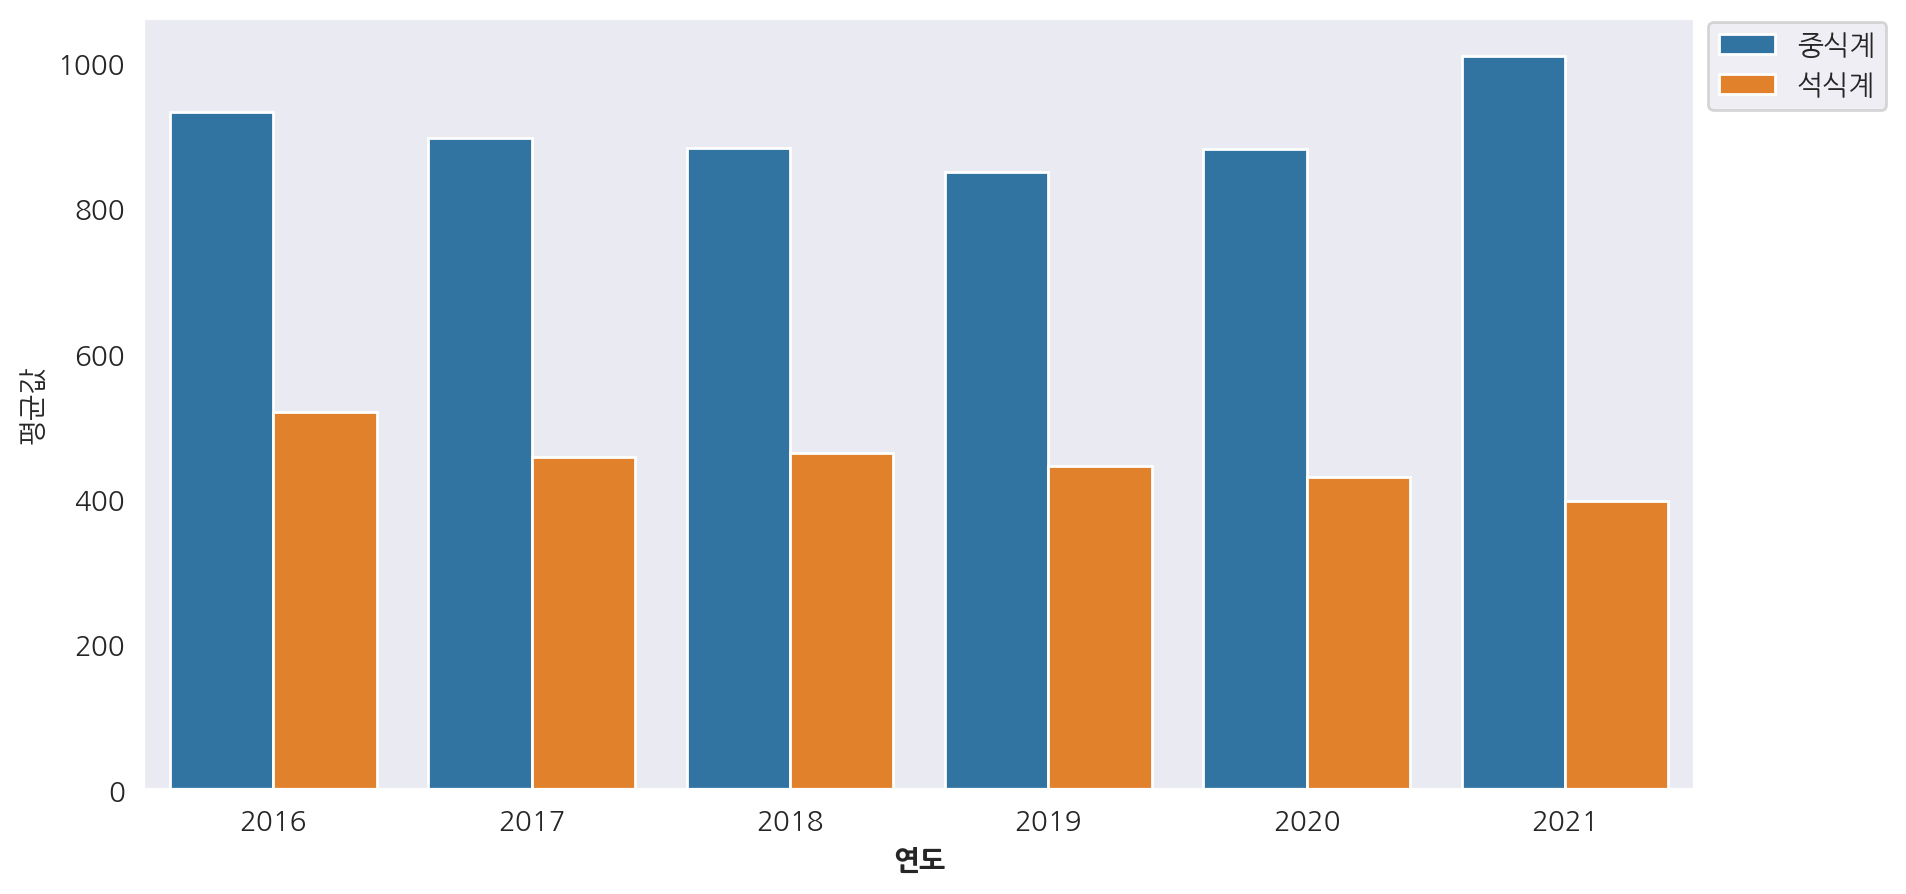

In [200]:
# 년도별 추이
melted_train = pd.melt(train, id_vars=['년'], value_vars=['중식계', '석식계'], var_name='식계', value_name='평균값')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(data=melted_train, x='년', y='평균값', hue='식계', errorbar=None)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.94))
ax.set_xlabel('연도', fontweight='bold')
plt.show()

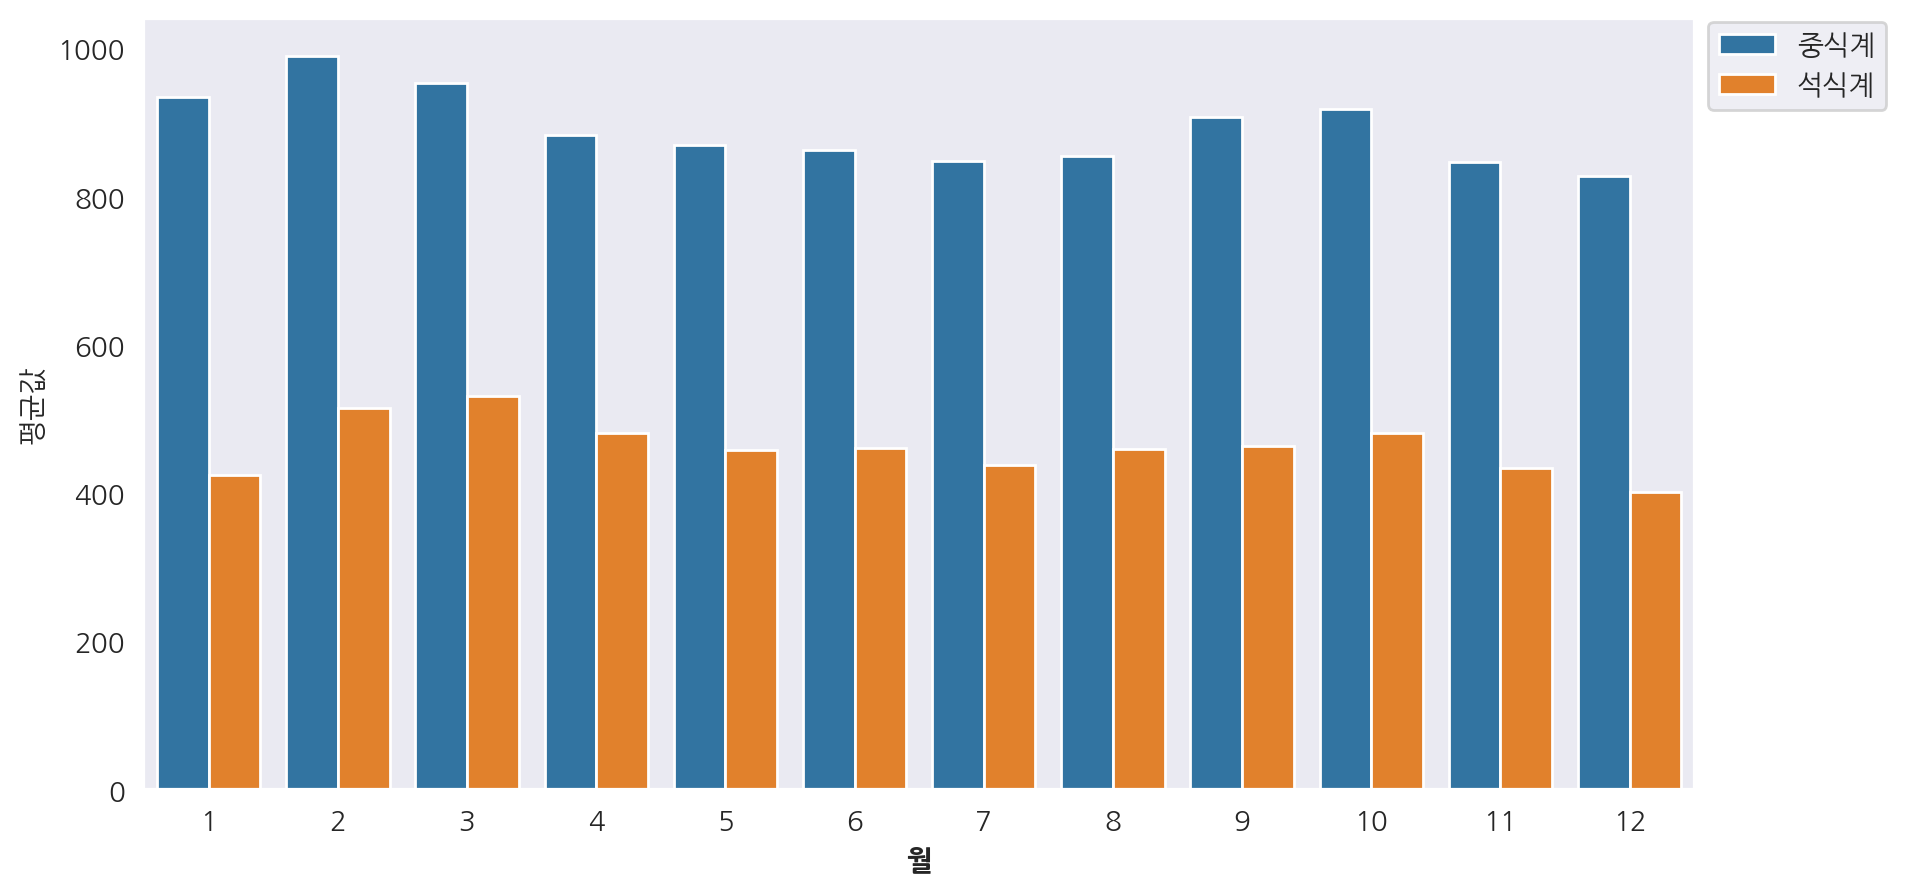

In [201]:
# 월별 추이
melted_train = pd.melt(train, id_vars=['월'], value_vars=['중식계', '석식계'], var_name='식계', value_name='평균값')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(data=melted_train, x='월', y='평균값', hue='식계', errorbar=None)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.94))
ax.set_xlabel('월', fontweight='bold')
plt.show()

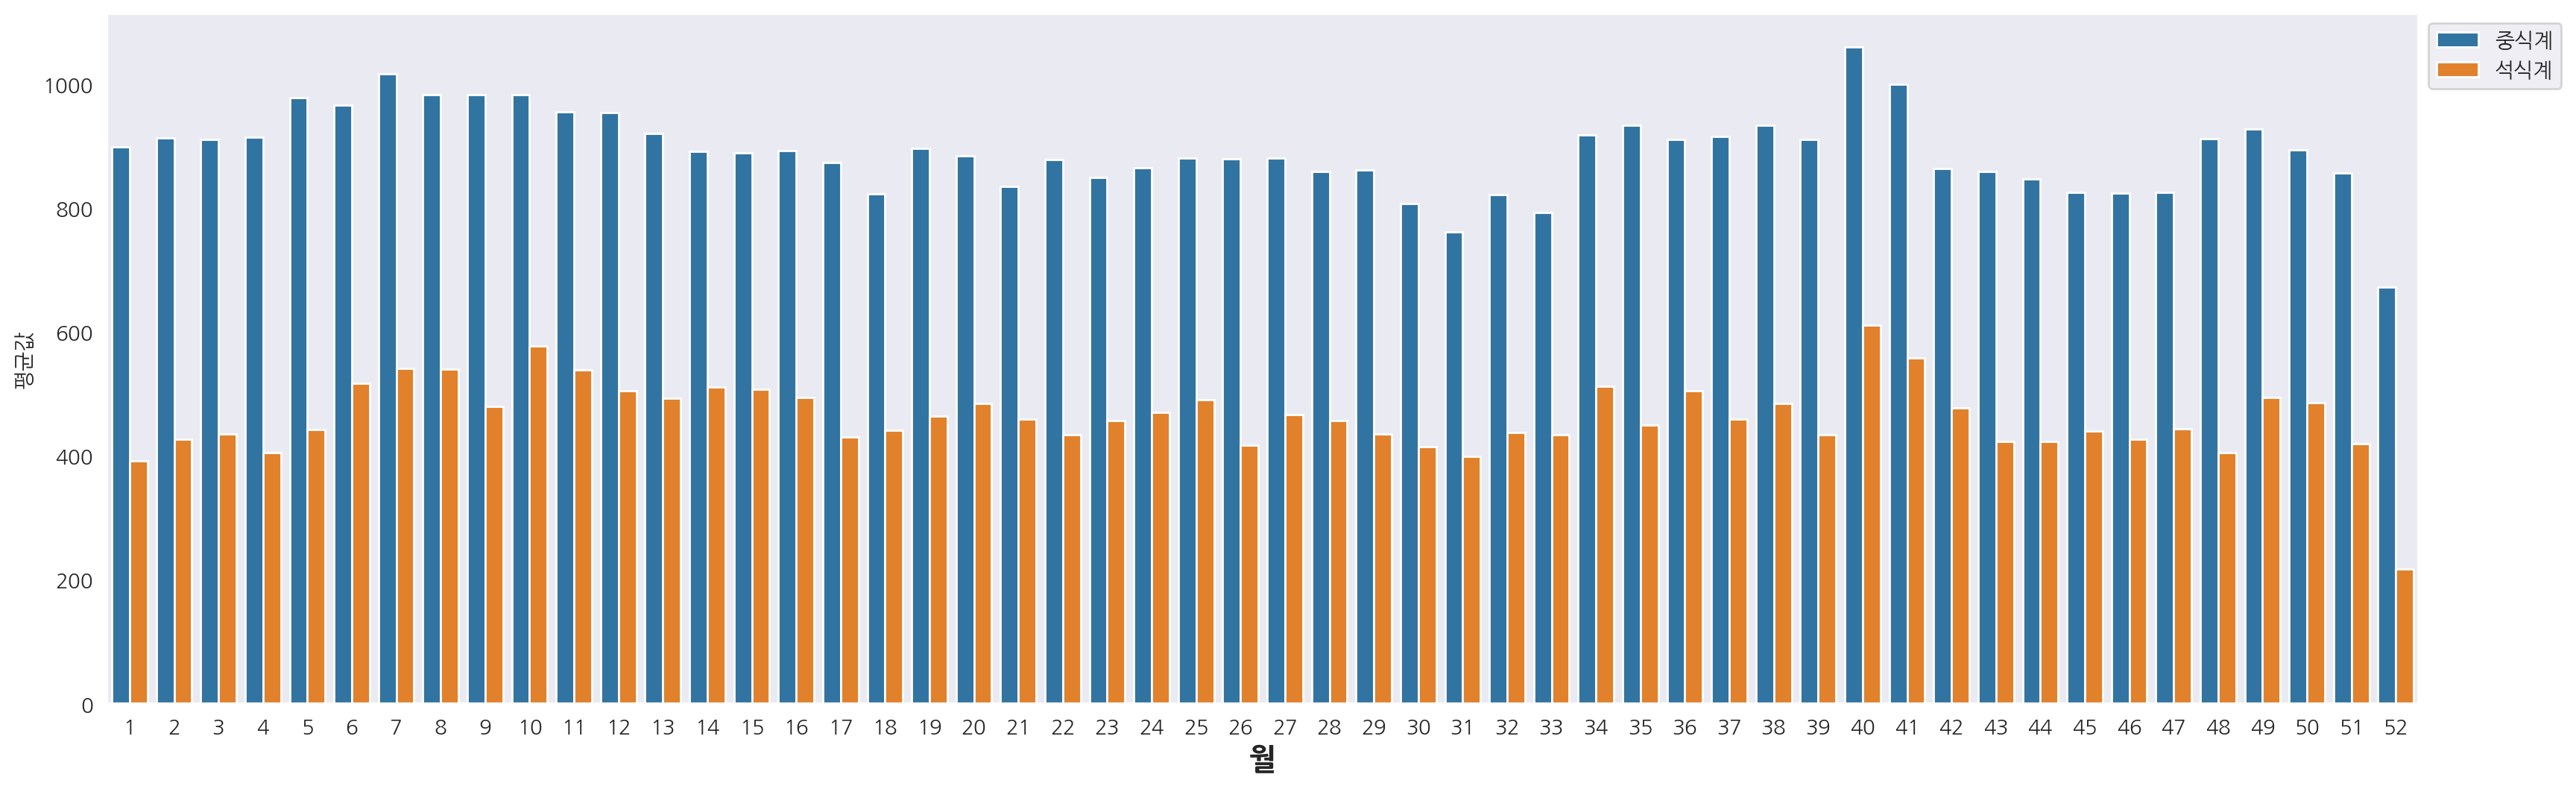

In [202]:
# 주별 추이
melted_train = pd.melt(train, id_vars=['주'], value_vars=['중식계', '석식계'], var_name='식계', value_name='평균값')
fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(data=melted_train, x='주', y='평균값', hue='식계', errorbar=None)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.94))
ax.set_xlabel('월', fontweight='bold', fontsize=14)
plt.show()

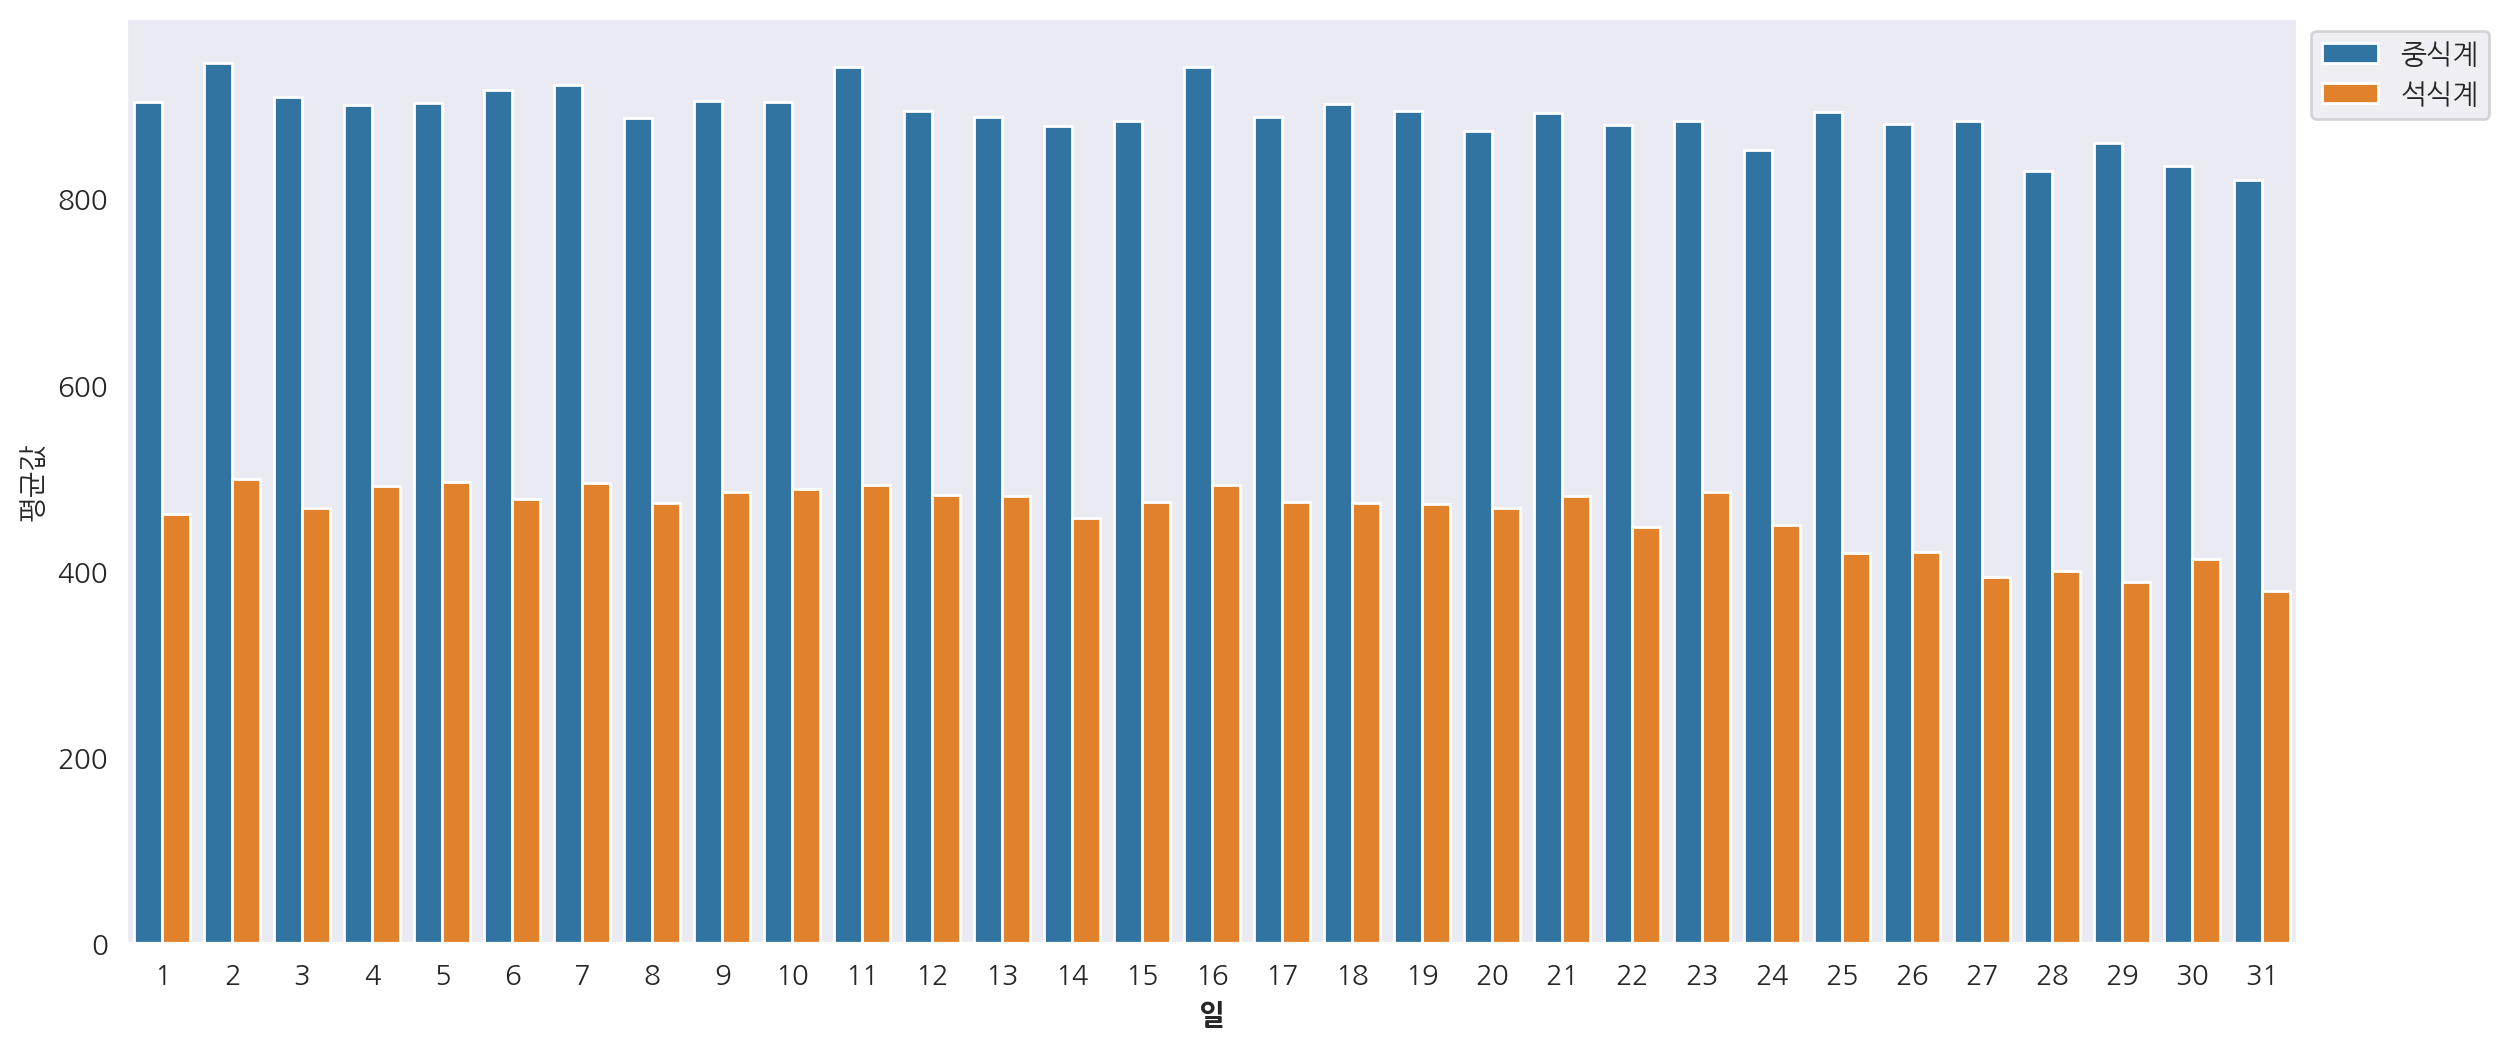

In [203]:
# 일별 추이
melted_train = pd.melt(train, id_vars=['일'], value_vars=['중식계', '석식계'], var_name='식계', value_name='평균값')
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=melted_train, x='일', y='평균값', hue='식계', errorbar=None)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.94))
ax.set_xlabel('일', fontweight='bold')
plt.show()

#### 요일 관련

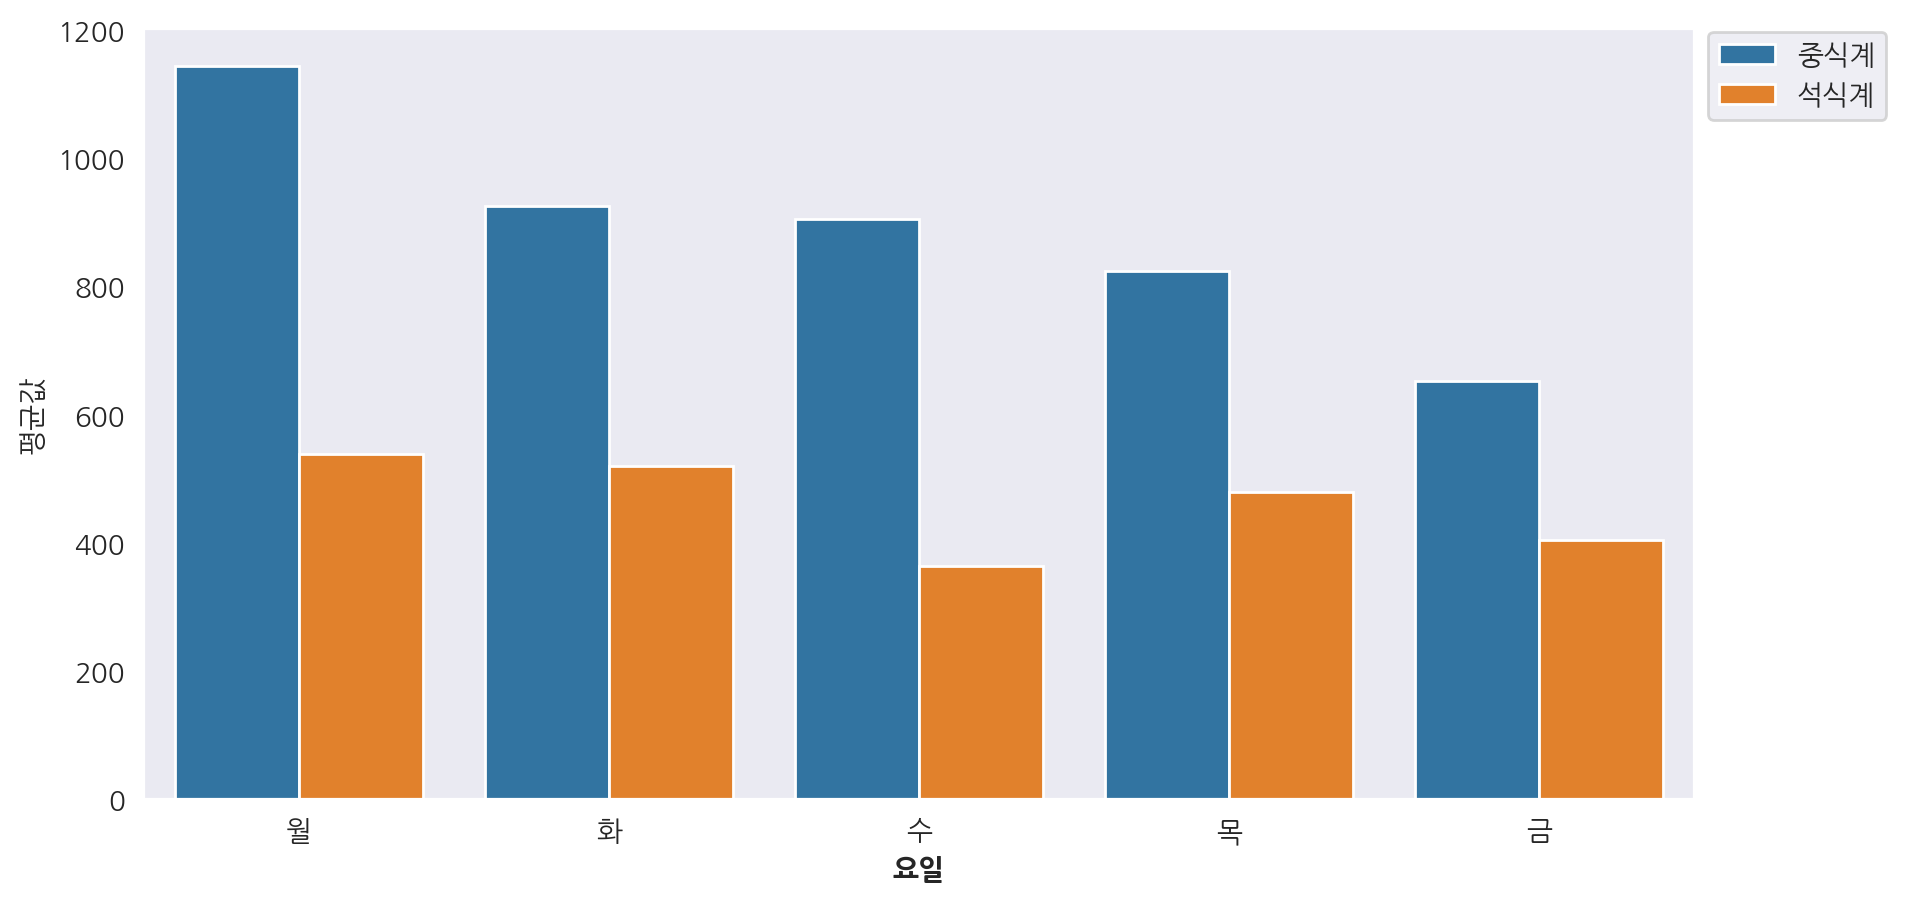

In [204]:
# 요일별 추이
melted_train = pd.melt(train, id_vars=['요일'], value_vars=['중식계', '석식계'], var_name='식계', value_name='평균값')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(data=melted_train, x='요일', y='평균값', hue='식계', errorbar=None)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.94))
ax.set_xlabel('요일', fontweight='bold')
plt.show()

In [205]:
# 석식 없는 날 비율(석식계 0인 요일 비율)
no_dinner = train[train['석식계'] == 0]
no_dinner['요일'].value_counts(1)

수    0.930233
금    0.046512
화    0.023256
Name: 요일, dtype: float64

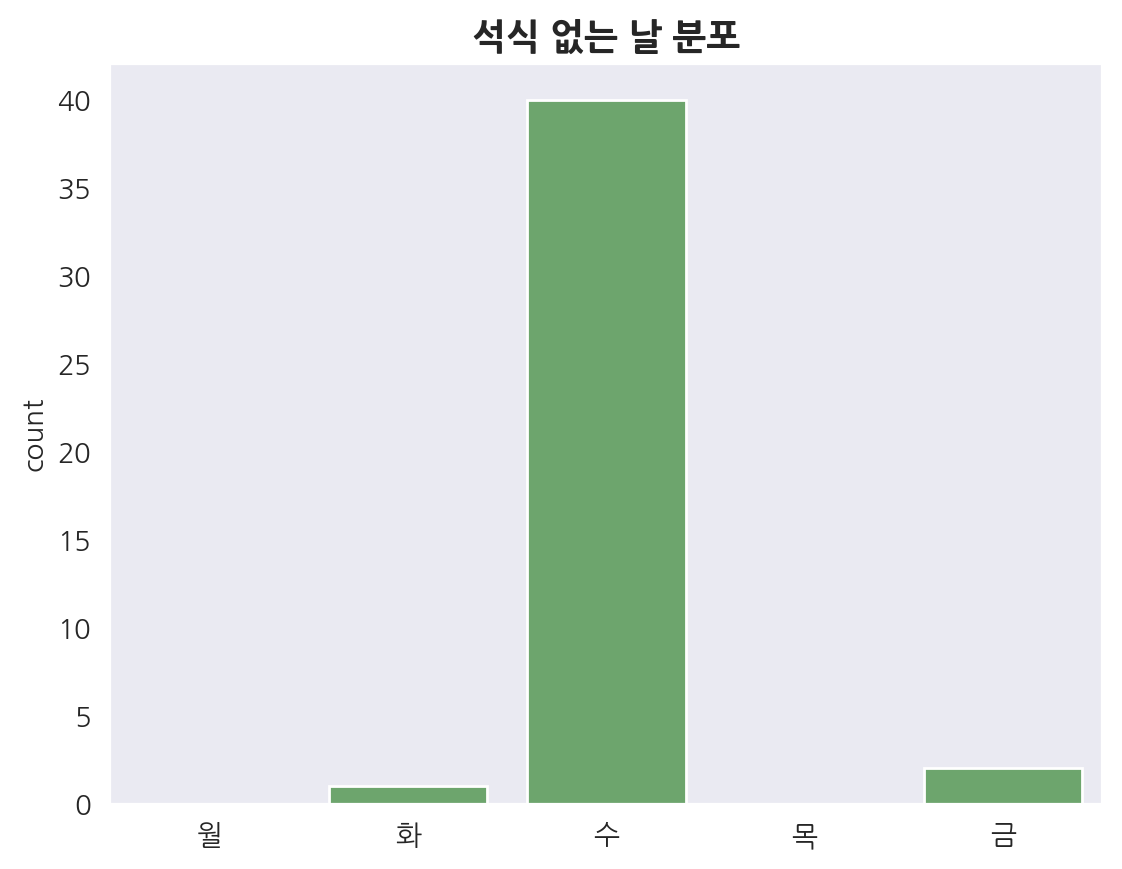

In [206]:
ax = sns.countplot(no_dinner, x = '요일', order = ['월','화','수','목','금'], color=green_code[1]);
ax.set_title('석식 없는 날 분포', fontsize=13, fontweight='bold')
ax.set_xlabel('')
plt.show()

In [207]:
# 중식 수치 - 요일별 평균
# 월화수목금 순으로 줄어든다.
train.groupby('요일').agg({'중식계':'mean',
                            '석식계':'mean'}).sort_values('중식계', ascending=False).style.background_gradient(subset=['중식계'])

,중식계,석식계
요일,,
월,1144.331950,538.933610
화,925.620833,520.129167
수,905.213389,363.615063
목,823.991803,480.401639
금,653.609959,404.979253


In [208]:
# 석식 수치 - 요일별 평균
# 월화목금수 순으로 줄어든다.
train.groupby('요일').agg({'중식계':'mean',
                            '석식계':'mean'}).sort_values('중식계', ascending=False).style.background_gradient(subset=['석식계'])

,중식계,석식계
요일,,
월,1144.331950,538.933610
화,925.620833,520.129167
수,905.213389,363.615063
목,823.991803,480.401639
금,653.609959,404.979253


#### 정원수 관련

In [209]:
n_train = train.copy()

In [210]:
n_train['일자']

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]

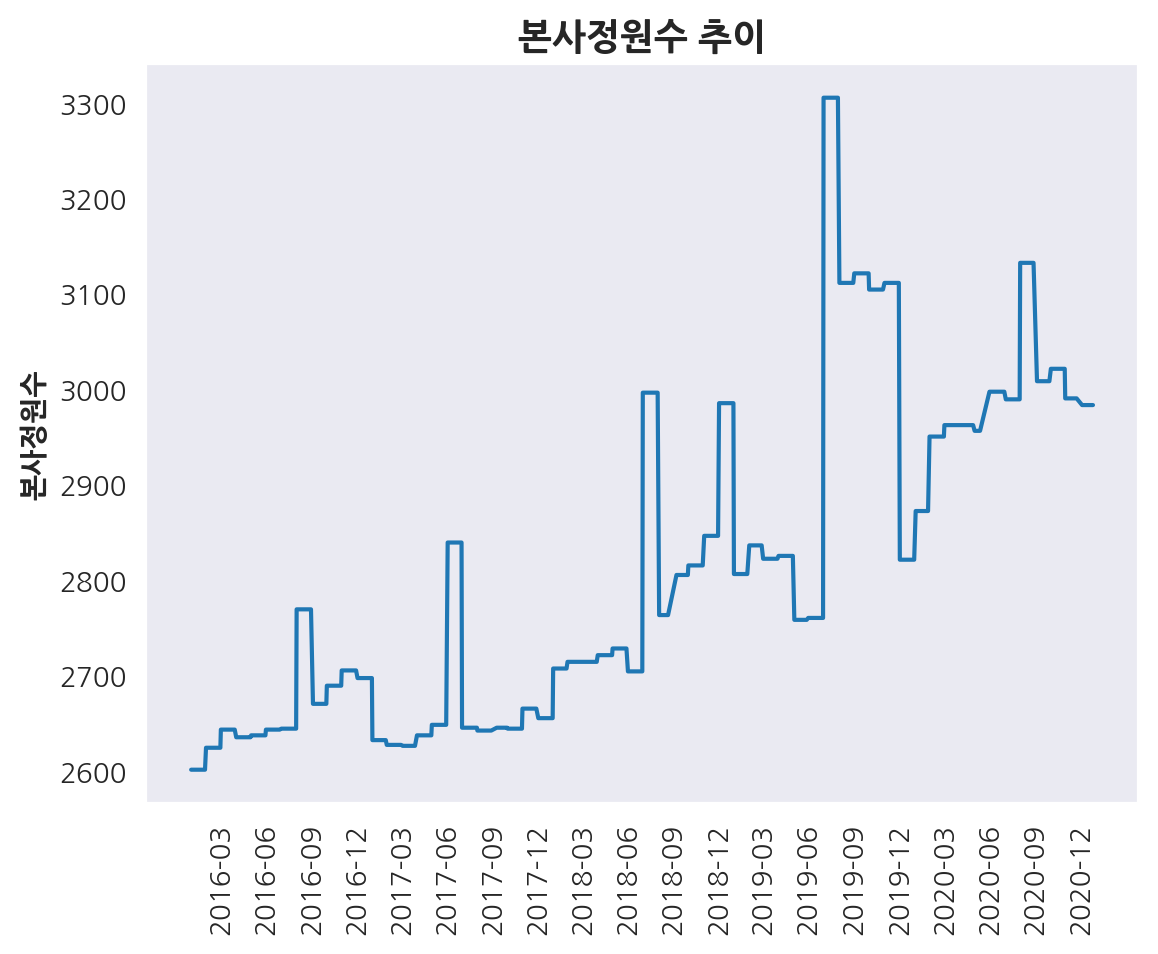

In [211]:
# 본사정원수가 꾸준히 증가함
# 성장하는 기업👍
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y-%m')

ax = sns.lineplot(train, x='일자', y='본사정원수')

plt.xticks(pd.date_range(start='2016-02-01', end='2021-01-31', freq='q'), rotation = 90)
ax.xaxis.set_major_formatter(myFmt)

ax.set_title('본사정원수 추이', fontsize=13, fontweight='bold')

ax.set_xlabel('')
ax.set_ylabel('본사정원수', fontweight='bold')

plt.show()

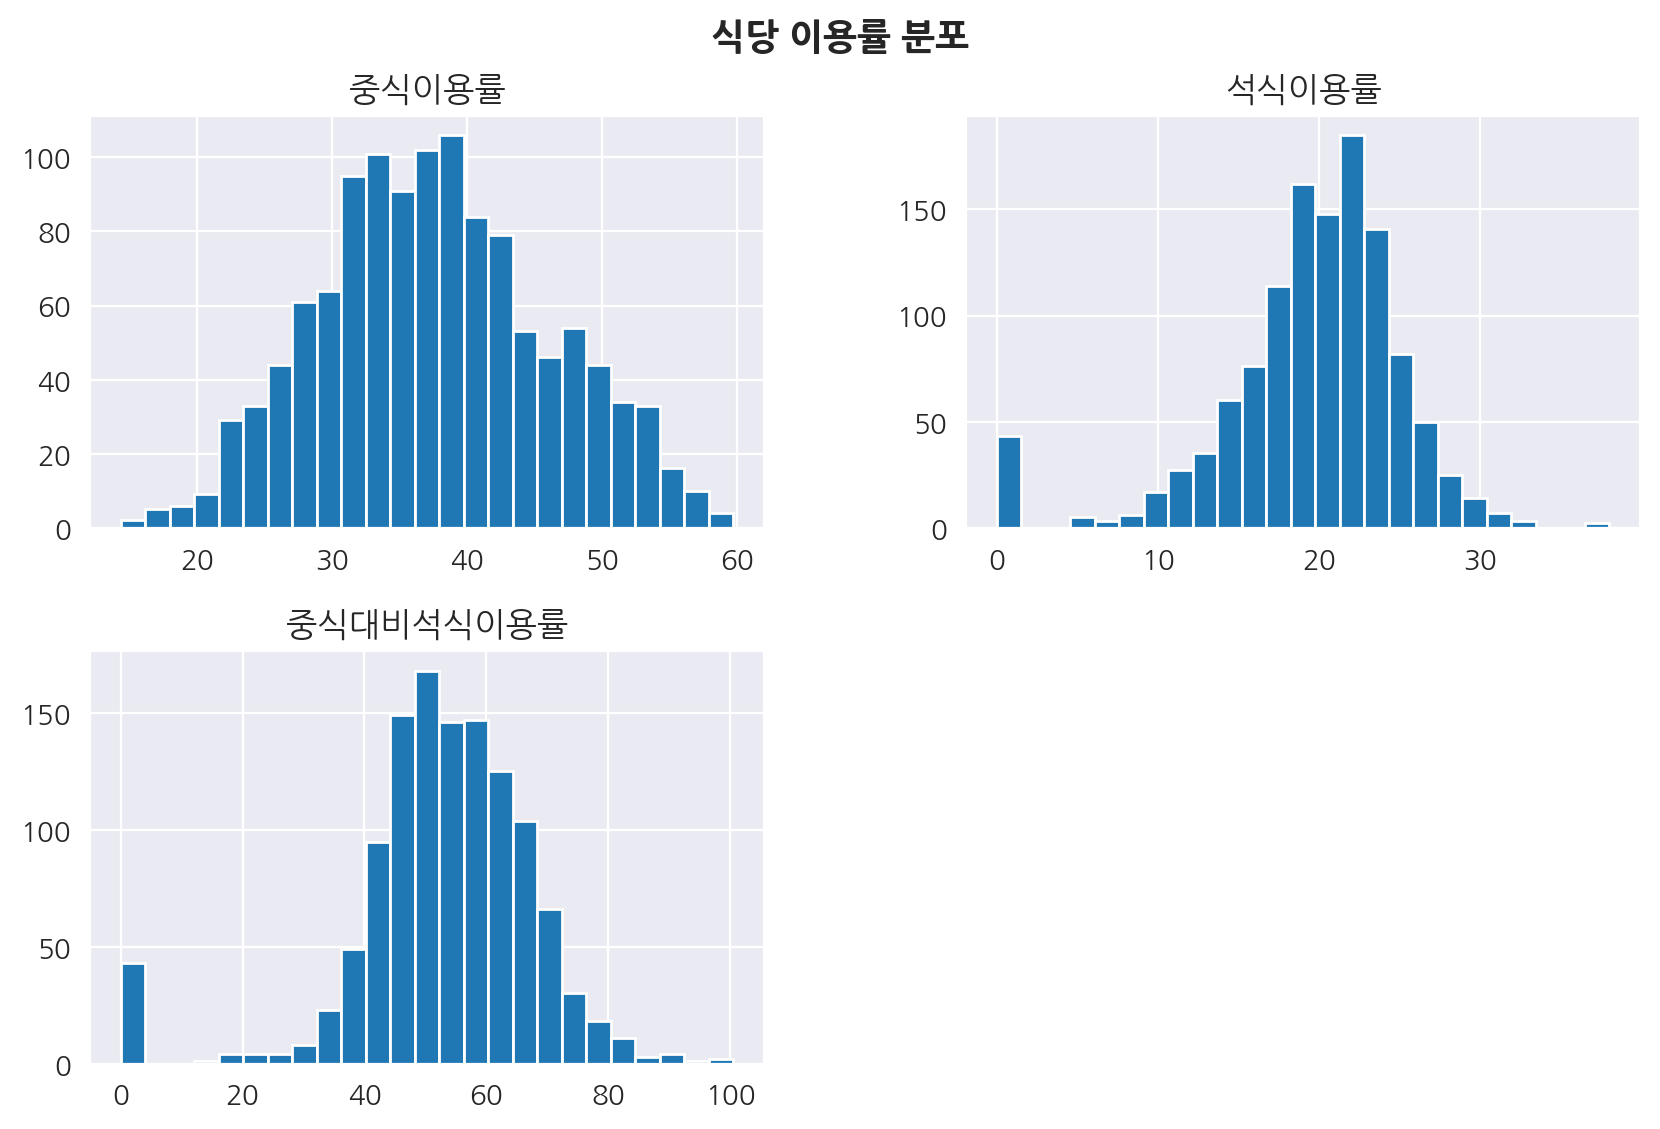

In [212]:
# 근무자 대비 식사 비율
train[['중식이용률', '석식이용률', '중식대비석식이용률']].hist(bins = 25, figsize=(10, 6));
plt.suptitle('식당 이용률 분포', fontsize=13, fontweight='bold')
plt.subplots_adjust(top=0.9)
plt.show()


In [213]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '중식메뉴', '석식메뉴', '중식계', '석식계', '미출근자수', '본사근무자수', '중식이용률',
       '석식이용률', '중식대비석식이용률', '년', '월', '일', '주', '년월'],
      dtype='object')

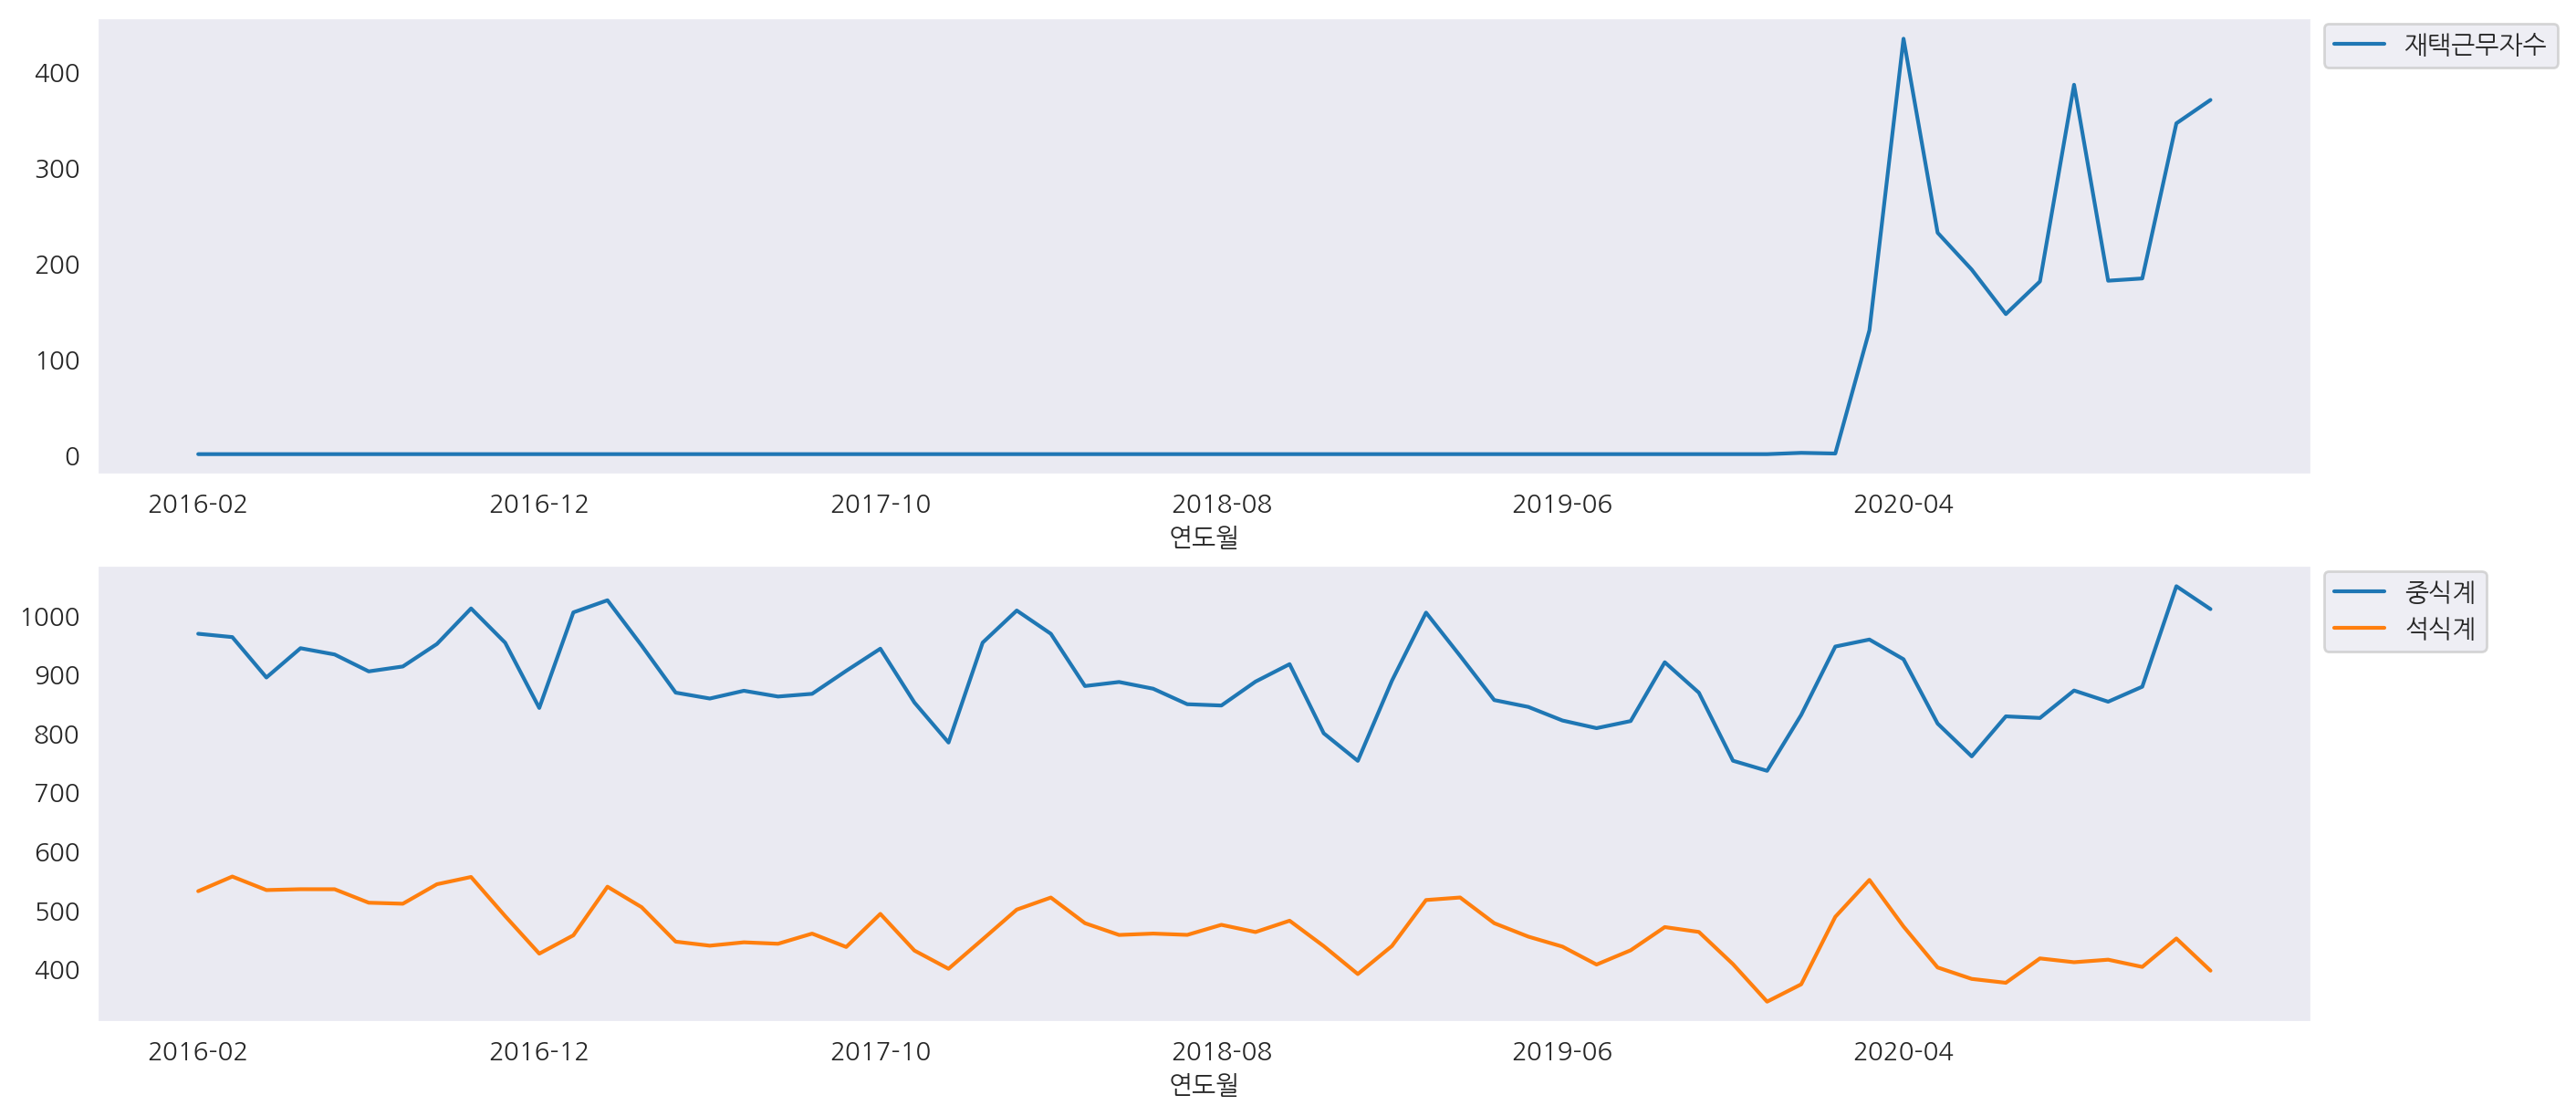

In [214]:
fig, axs = plt.subplot_mosaic(
    [['1'],
     ['2']],
    figsize=(14, 6), 
    layout='constrained')

년도별_특수인원 = train[['년월', '현본사소속재택근무자수']].groupby('년월').mean()
# 년도별_정원_인원 = train[['년월','본사정원수','본사근무자수']].groupby('년월').mean()
식수 = train[['년월', '중식계', '석식계']].groupby('년월').mean()



년도별_특수인원.plot(kind='line', ax=axs['1'])
# 년도별_정원_인원.plot(kind='line', ax=axs['2'])
식수.plot(kind='line', ax=axs['2'])

axs['1'].legend(['재택근무자수'], loc='center left', bbox_to_anchor=(1, 0.94))
axs['2'].legend(loc='center left', bbox_to_anchor=(1, 0.9))

axs['1'].set_xlabel('연도월')
axs['2'].set_xlabel('연도월');

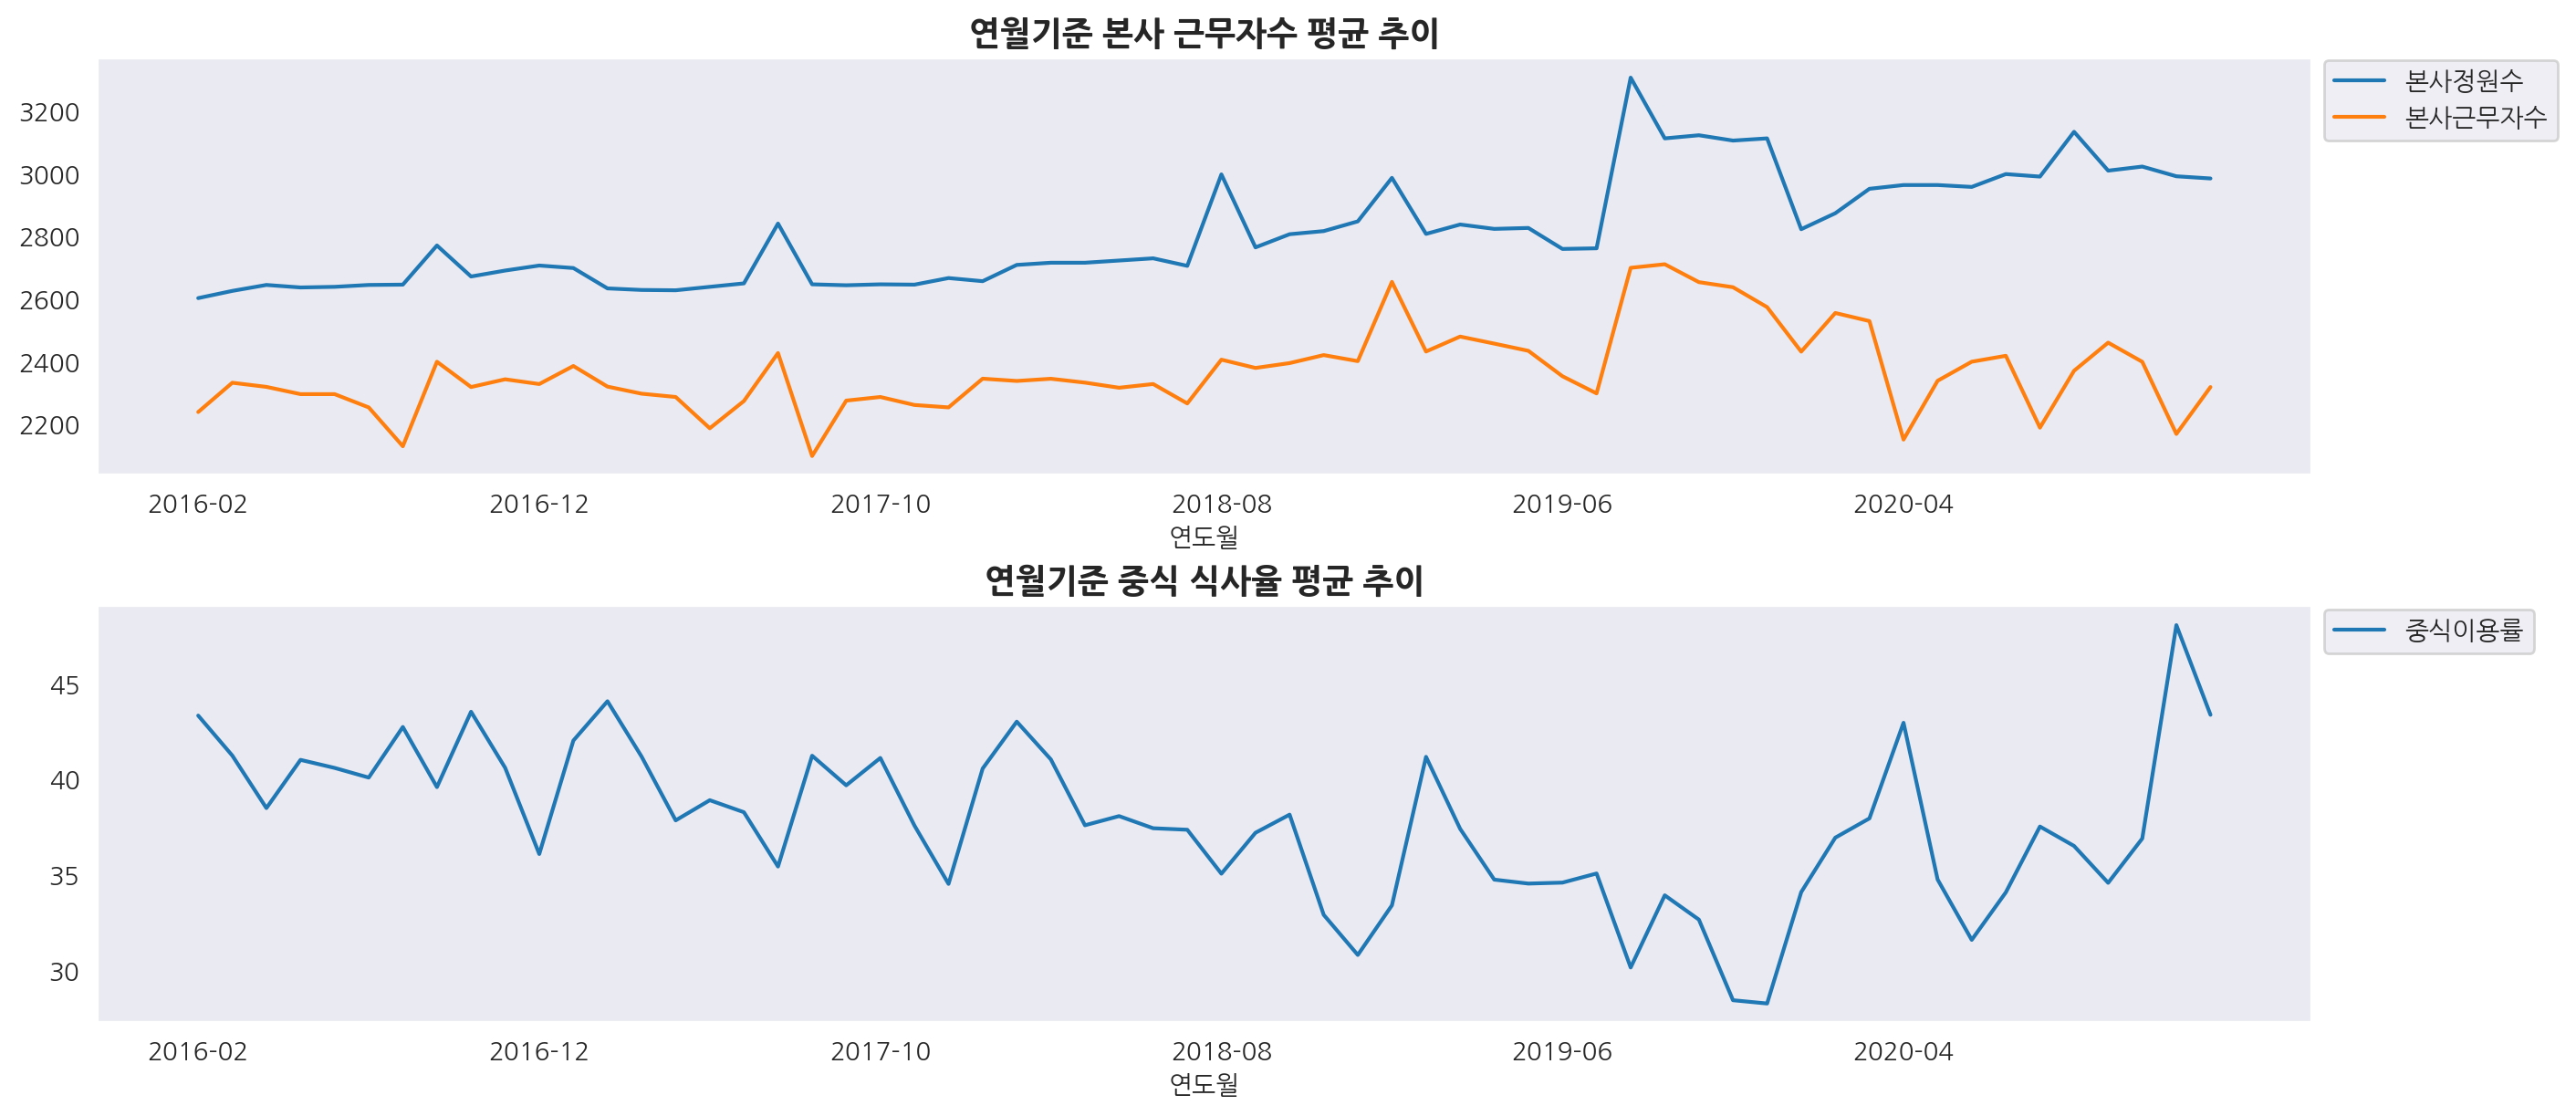

In [215]:
fig, axs = plt.subplot_mosaic(
    [['1'],
     ['2']],
    figsize=(14, 6), 
    layout='constrained')

년도별_정원_인원 = train[['년월','본사정원수','본사근무자수']].groupby('년월').mean()
중식계_평균 = train[['년월','중식이용률']].groupby('년월').mean()

년도별_정원_인원.plot(kind='line', ax=axs['1'])
중식계_평균.plot(kind='line', ax=axs['2'])

axs['1'].set_title('연월기준 본사 근무자수 평균 추이', fontsize=13, fontweight='bold')
axs['2'].set_title('연월기준 중식 식사율 평균 추이', fontsize=13, fontweight='bold')

axs['1'].legend(loc='center left', bbox_to_anchor=(1, 0.9))
axs['2'].legend(loc='center left', bbox_to_anchor=(1, 0.94))

axs['1'].set_xlabel('연도월')
axs['2'].set_xlabel('연도월');

#### 휴가자수 관련

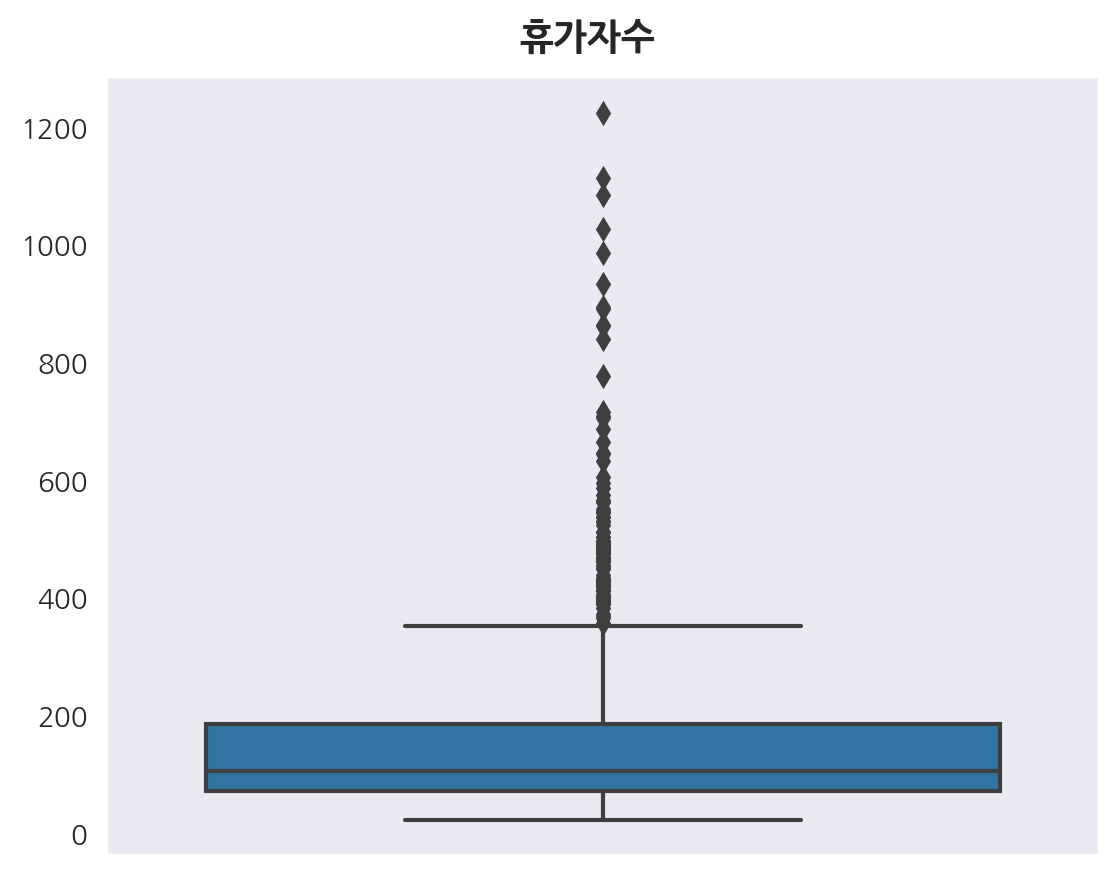

In [216]:
fig, ax = plt.subplots()
sns.boxplot(train['본사휴가자수']);
plt.suptitle('휴가자수', fontsize=13, fontweight='bold')
plt.subplots_adjust(top=0.92)
ax.set_xticks([]);

In [217]:
# 휴가자수 이상치 확인
q3, q1 = train['본사휴가자수'].describe()['75%'], train['본사휴가자수'].describe()['25%']
iqr = q3 - q1
upper_whisker = q3 +1.5 * iqr

print(upper_whisker)
train[train['본사휴가자수'] > upper_whisker]['요일'].value_counts()

356.0


금    32
월    24
목    20
화    16
수    16
Name: 요일, dtype: int64

In [218]:
# 휴일 전날이나 연말 등 휴가자 비율이 높을 것으로 예상되는 날짜에 대한 처리 필요
train.sort_values('본사휴가자수', ascending = False).head(5)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,...,미출근자수,본사근무자수,중식이용률,석식이용률,중식대비석식이용률,년,월,일,주,년월
310,2017-05-04,목,2637,1224,41,45,0.0,쌀밥/잡곡밥 (쌀:국내산) 들깨미역국 닭갈비 생선까스*타르소스 무생채 포기김...,야채볶음밥 (쌀:국내산) 유부주머니국 미니버거 야채비빔만두 스틱단무지/오렌지주...,383.0,...,1265.0,1372.0,27.915452,19.096210,68.407311,2017,5,4,18,2017-05
1038,2020-05-04,월,2962,1113,117,91,189.0,"쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 버섯들깨국 삼겹살더덕고추장구이 곰취,명이나...","쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 다슬기아욱국 갈릭파닭 돈채호박볶음 짠지오...",504.0,...,1419.0,1543.0,32.663642,7.971484,24.404762,2020,5,4,19,2020-05
709,2018-12-31,월,2846,1085,132,28,0.0,쌀밥/잡곡밥 (쌀:국내산) 콩나물국 돈육고추장불고기 (돼지고기:국내산) 감자채볶음...,쌀밥/잡곡밥 (쌀:국내산) 들깨시래기국 훈제오리볶음 계란찜 참나물생채 포기김...,332.0,...,1217.0,1629.0,20.380602,8.287293,40.662651,2018,12,31,1,2018-12
864,2019-08-16,금,3305,1026,208,7,0.0,쌀밥/잡곡밥 (쌀:국내산) 닭개장 쇠고기장조림 잡채 비름나물된장무침 포기김치...,쌀밥/잡곡밥 (쌀:국내산) 해물짬뽕국 돈육굴소스볶음 쇠고기두부찜 멸치볶음 열...,466.0,...,1234.0,2071.0,22.501207,15.113472,67.167382,2019,8,16,33,2019-08
1129,2020-09-28,월,3132,985,188,81,142.0,쌀밥/흑미밥/찰현미밥 떡만두국 오리대패불고기 꽁치캔김치조림 파프리카해초무침 포기김치...,흑미밥 우거지된장국 닭볶음탕 섭산적데리야끼조림 콩나물무침 포기김치,358.0,...,1315.0,1817.0,19.702807,9.080903,46.089385,2020,9,28,40,2020-09


In [219]:
holiday = holiday.iloc[1:78,:] # train 데이터셋에 포함되는 날짜까지 선택
holiday['일자'] = pd.to_datetime(holiday['날짜'])
holiday = holiday[['일자', '공휴일', '요일']]
holiday = holiday[~holiday['요일'].isin(['토','일'])]
holiday = holiday[['일자', '공휴일']]
holiday.head(3)

,일자,공휴일
2,2016-02-08,설날
3,2016-02-09,설날 연휴
4,2016-03-01,3·1절


In [220]:
all_holiday = pd.merge(train, holiday, how='outer', on='일자')
all_holiday = all_holiday.sort_values(by='일자')
holiday_idx = all_holiday['공휴일'].notna() #공휴일 여부를 확인해주고
all_holiday.loc[holiday_idx.shift(-1, fill_value=False) | holiday_idx.shift(1, fill_value=False) | holiday_idx, '공휴일_YN'] = 1 # 해당 행의 윗행, 아래행, 해당 행에 '공휴일_YN' column을 추가하고 값을 1로 설정
all_holiday.loc[all_holiday['공휴일_YN'].isna(), '공휴일_YN'] = 0
all_holiday.head(30)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,...,중식이용률,석식이용률,중식대비석식이용률,년,월,일,주,년월,공휴일,공휴일_YN
0,2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,...,43.273636,13.785923,31.857555,2016.0,2.0,1.0,5.0,2016-02,NaN,0.0
1,2016-02-02,화,2601.0,50.0,173.0,319.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,...,36.459209,23.549201,64.590542,2016.0,2.0,2.0,5.0,2016-02,NaN,0.0
2,2016-02-03,수,2601.0,56.0,180.0,111.0,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,...,43.002114,24.228330,56.342183,2016.0,2.0,3.0,5.0,2016-02,NaN,0.0
3,2016-02-04,목,2601.0,104.0,220.0,355.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,...,42.951252,23.056653,53.680982,2016.0,2.0,4.0,5.0,2016-02,NaN,0.0
4,2016-02-05,금,2601.0,278.0,181.0,34.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,...,43.183940,15.406162,35.675676,2016.0,2.0,5.0,5.0,2016-02,NaN,1.0
1205,2016-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,설날,1.0
1206,2016-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,설날 연휴,1.0
5,2016-02-11,목,2601.0,383.0,143.0,417.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045.0,...,50.361446,26.506024,52.631579,2016.0,2.0,11.0,6.0,2016-02,NaN,1.0
6,2016-02-12,금,2601.0,389.0,156.0,93.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909.0,...,44.212062,29.085603,65.786579,2016.0,2.0,12.0,6.0,2016-02,NaN,0.0
7,2016-02-15,월,2601.0,87.0,204.0,482.0,0.0,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268.0,...,54.891775,29.090909,52.996845,2016.0,2.0,15.0,7.0,2016-02,NaN,0.0


In [221]:
all_holiday = all_holiday[~all_holiday['본사정원수'].isna()] # 식수데이터 없는 날 빼기
all_holiday = all_holiday[~all_holiday['요일'].isin(['토','일'])] # 주말 빼기
all_holiday.drop('공휴일', axis=1, inplace=True) # 휴일명 값이 있는 행은 어차피 식수데이터 없어서 빠짐

In [222]:
# all_holiday.tail(30)

In [223]:
n_train = n_train[['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '중식메뉴', '석식메뉴', '중식계', '석식계']]

In [224]:
n_train = n_train.rename(columns={'본사시간외근무명령서승인건수':'추가근무건수', '현본사소속재택근무자수':'재택근무자수'})

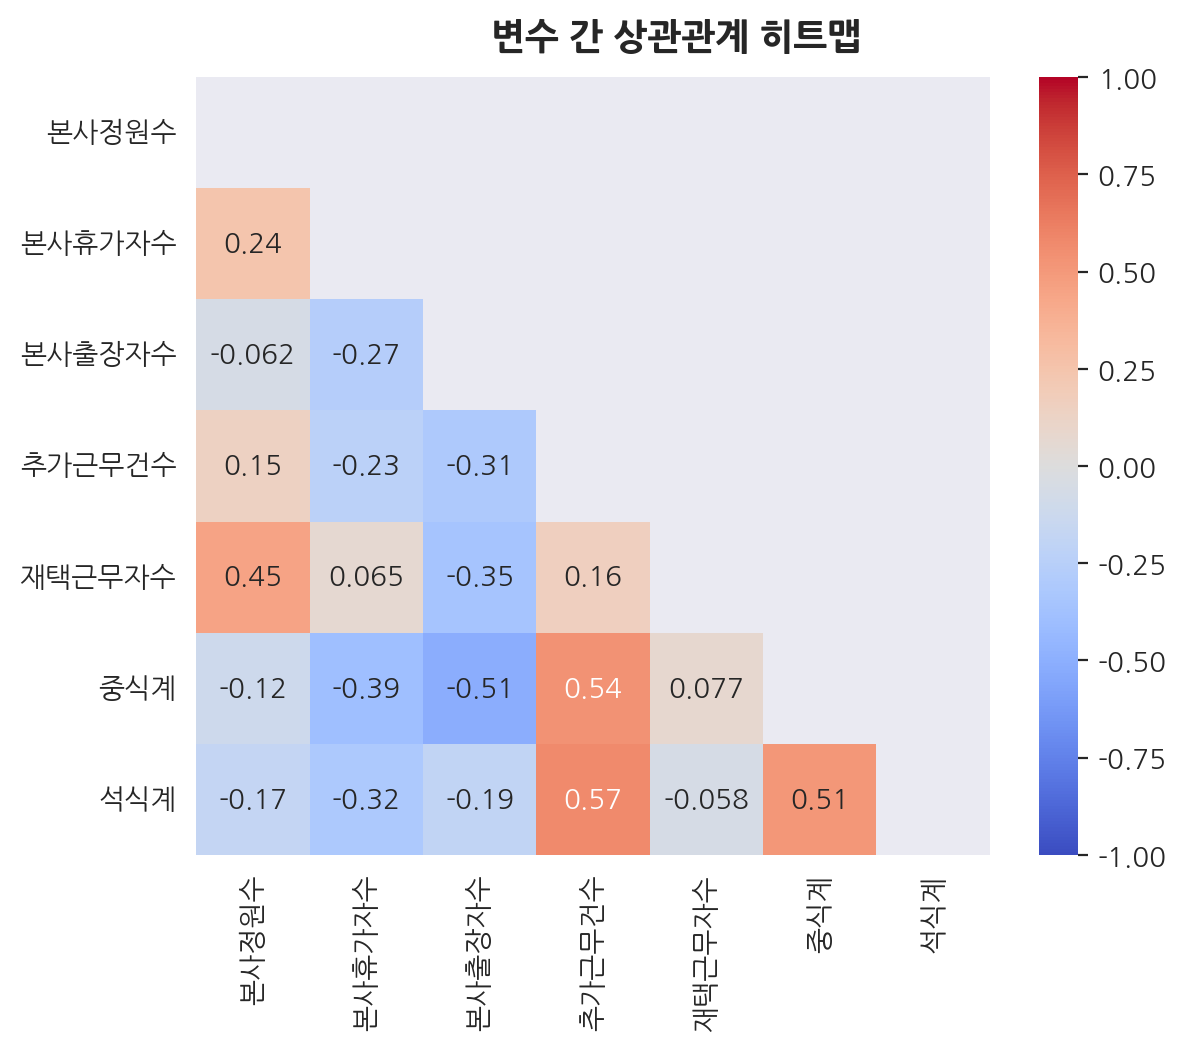

In [225]:
mask = np.triu(np.ones_like(n_train.drop(columns='요일').corr()))


sns.heatmap(n_train.drop(columns='요일').corr(),
            annot=True,
            vmin=-1, vmax=1,
            cmap='coolwarm',
            mask=mask);

plt.suptitle('변수 간 상관관계 히트맵', fontsize=13, fontweight='bold')
plt.subplots_adjust(top=0.92)

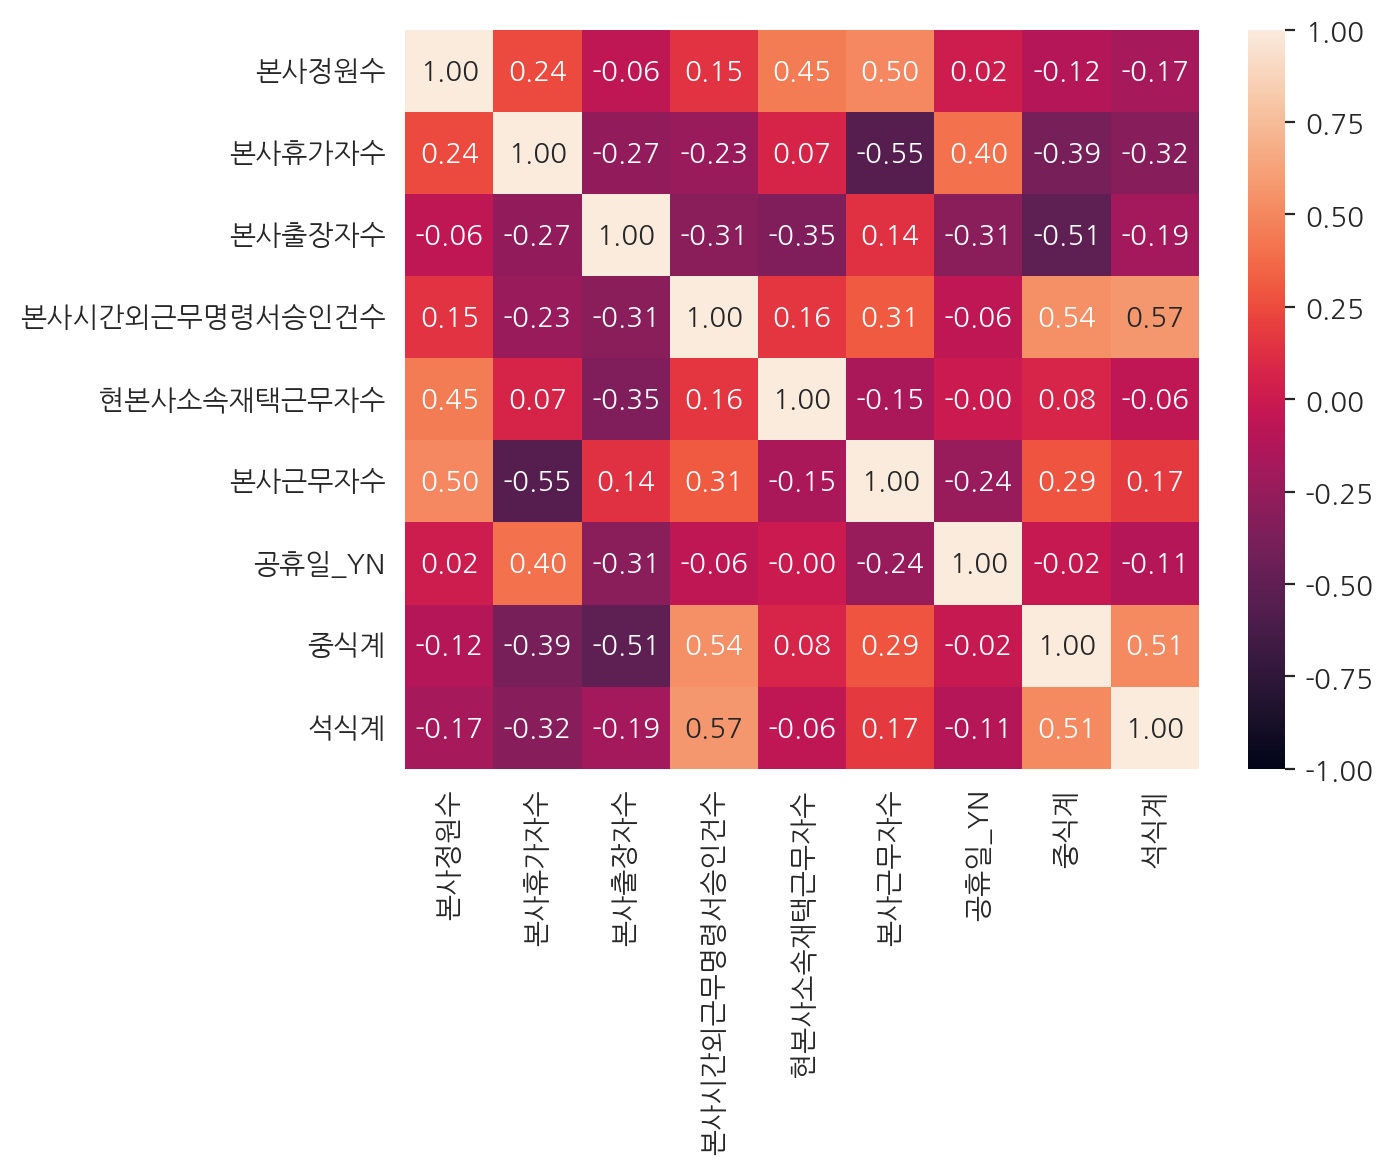

In [226]:
all_corr = all_holiday[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '본사근무자수', '공휴일_YN', '중식계', '석식계']]

sns.heatmap(all_corr.corr(), annot =True, fmt = ',.2f', vmin = -1, vmax = 1);

#### 출장자수 관련

#### 본사시간외근무명령서승인건수(야근자수) 관련

In [227]:
# 수요일 일부가 자기개발의날로 야근 없음
train[(train['본사시간외근무명령서승인건수'] == 0) & (train['석식계'] == 0)].head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,...,미출근자수,본사근무자수,중식이용률,석식이용률,중식대비석식이용률,년,월,일,주,년월
204,2016-11-30,수,2689,68,207,0,0.0,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,None,1109.0,...,275.0,2414.0,45.940348,0.0,0.0,2016,11,30,48,2016-11
224,2016-12-28,수,2705,166,225,0,0.0,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,None,767.0,...,391.0,2314.0,33.146067,0.0,0.0,2016,12,28,52,2016-12
244,2017-01-25,수,2697,79,203,0,0.0,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,None,720.0,...,282.0,2415.0,29.813665,0.0,0.0,2017,1,25,4,2017-01


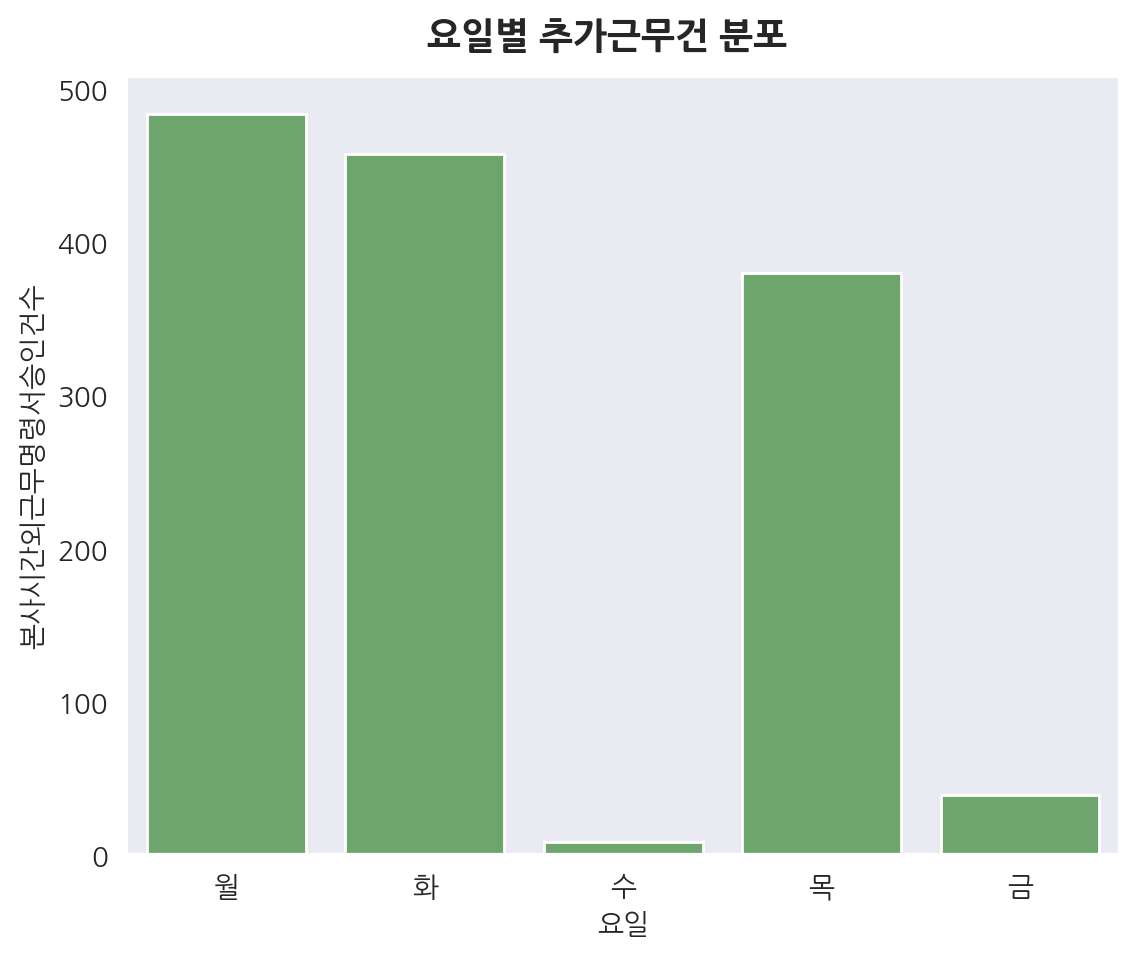

In [228]:
# 수요일이 극단적으로 적음
sns.barplot(train, x = '요일', y = '본사시간외근무명령서승인건수', color=green_code[1], errorbar=None);

plt.suptitle('요일별 추가근무건 분포', fontsize=13, fontweight='bold')
plt.subplots_adjust(top=0.92)

,일자,본사시간외근무명령서승인건수
652,2018-10-10,1044
894,2019-10-02,310
18,2016-03-02,261
2,2016-02-03,111
9,2016-02-17,23
...,...,...
505,2018-02-21,0
510,2018-02-28,0
514,2018-03-07,0
519,2018-03-14,0


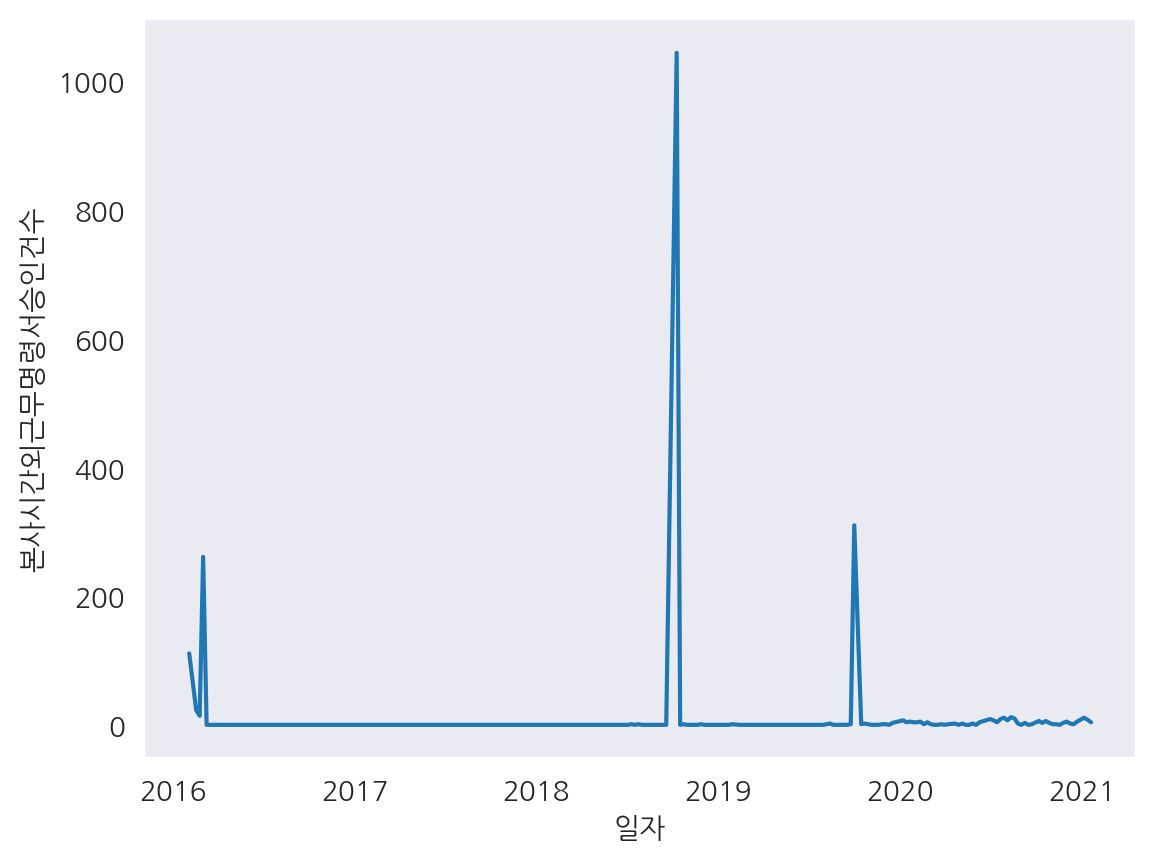

In [229]:
overwork_wed = train[train['요일'] == '수'][['일자','본사시간외근무명령서승인건수']]
display(overwork_wed.sort_values(by='본사시간외근무명령서승인건수' ,ascending=False))
sns.lineplot(overwork_wed, x = '일자', y = '본사시간외근무명령서승인건수');

,일자,본사시간외근무명령서승인건수
895,2019-10-04,428
171,2016-10-14,172
704,2018-12-21,163
206,2016-12-02,152
211,2016-12-09,152
...,...,...
806,2019-05-24,0
1084,2020-07-24,0
1089,2020-07-31,0
995,2020-02-28,0


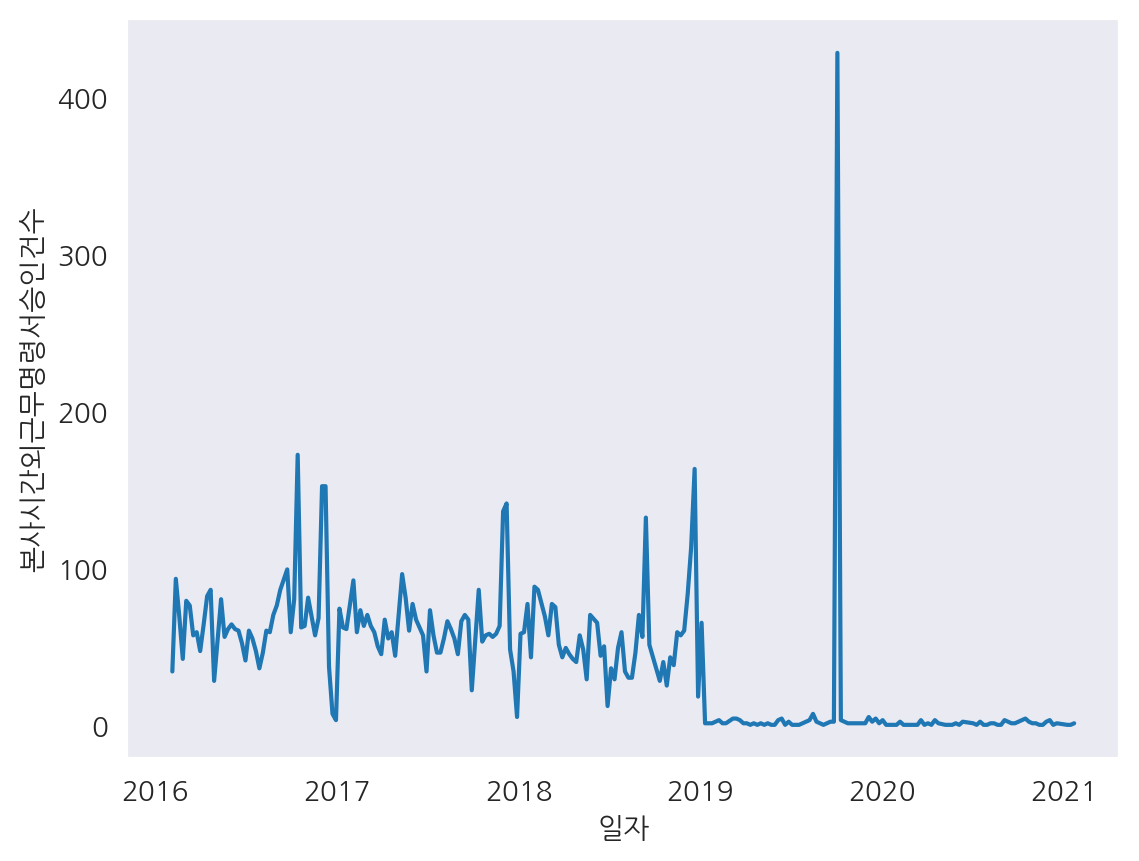

In [230]:
overwork_fri = train[train['요일'] == '금'][['일자','본사시간외근무명령서승인건수']]
display(overwork_fri.sort_values(by='본사시간외근무명령서승인건수' ,ascending=False))
sns.lineplot(overwork_fri, x = '일자', y = '본사시간외근무명령서승인건수');

**가설 : 추가근무(본사시간외근무명령승인건수)가 많으면, 식사하는 인원이 많아질 것이다.(특히, 석식계의 경우)**
- 확인 : '본사시간외근무명령승인건수'와 중식계, 석식계의 관계는 양의 상관관계를 나타내지만 기대만큼 높은 수치는 아니었다.
- 유의미한 수치는 아니지만 미출근자 수가 중식계와 석식계와의 관계에서 양의 상관관계를 보였다.(출근자 수와 비교하여) 하지만 이는 위의 분포 시각화를 보았을 때나 상관계수를 보았을 때나 유의미한 수치는 아니다.
- 미출근자가 많을수록 추가근무자수가 많다는 것은, 그만큼 미출근자의 공백을 메우기 위함인 것으로 보인다.

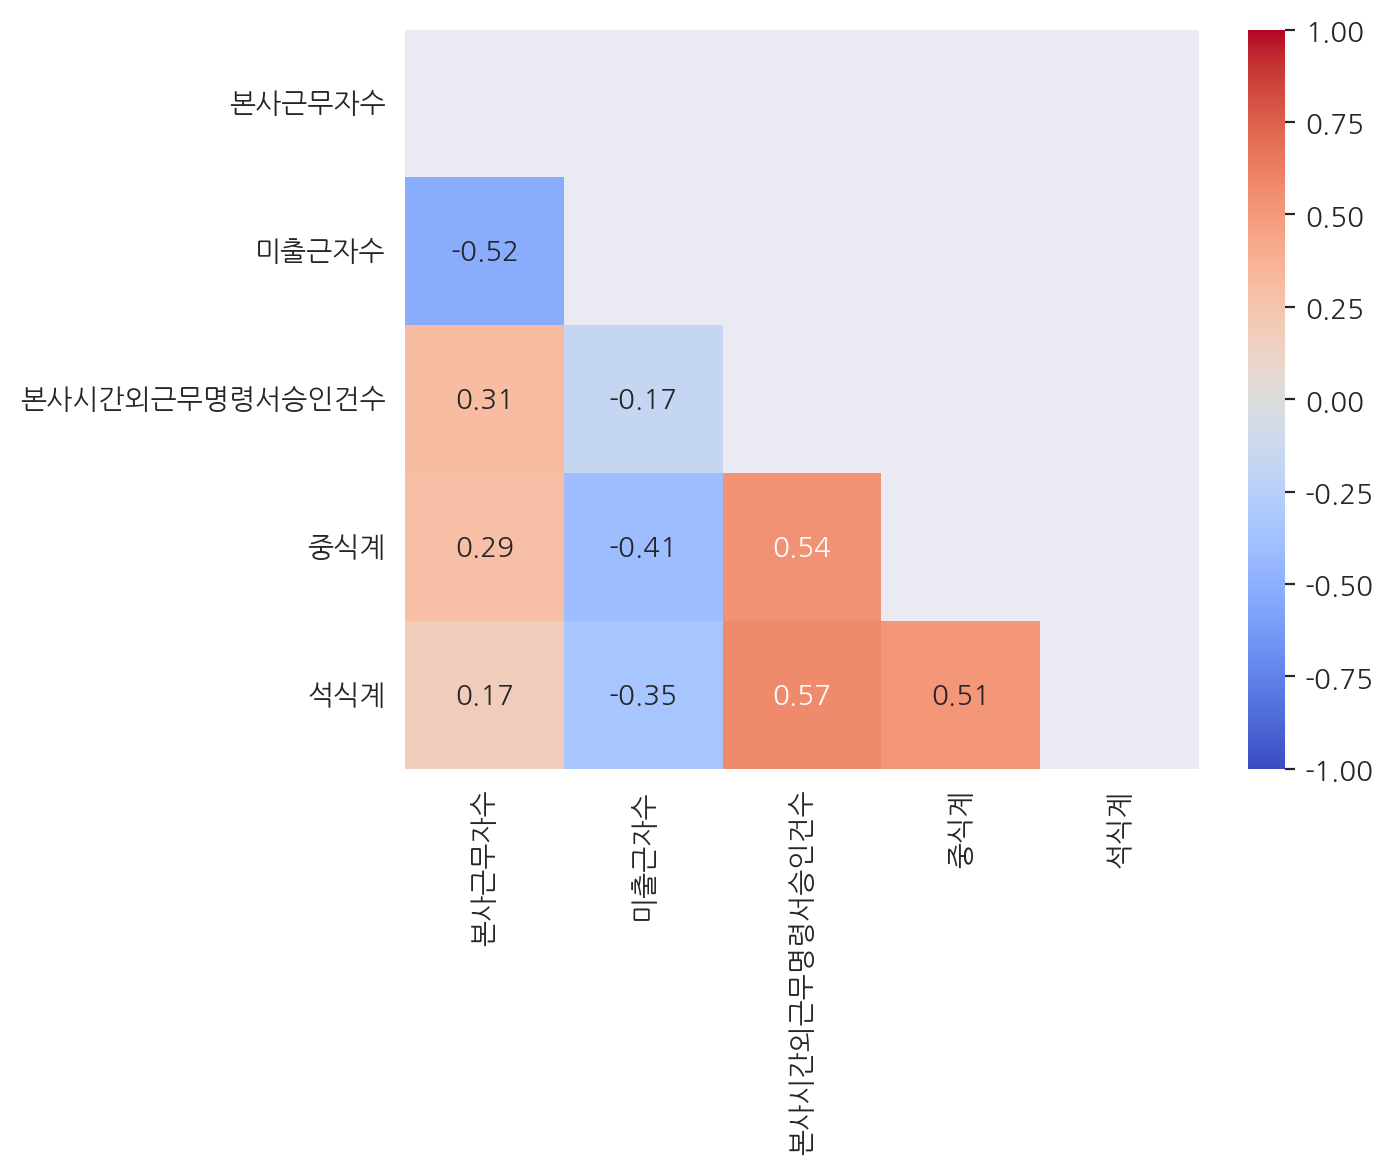

In [231]:
detail_corr = train[['본사근무자수', '미출근자수', '본사시간외근무명령서승인건수', '중식계', '석식계']].corr()
mask = np.triu(np.ones_like(detail_corr))

sns.heatmap(detail_corr,
            annot=True,
            vmin=-1, vmax=1,
            cmap='coolwarm',
            mask=mask);

#### 현본사소속재택근무자수 관련

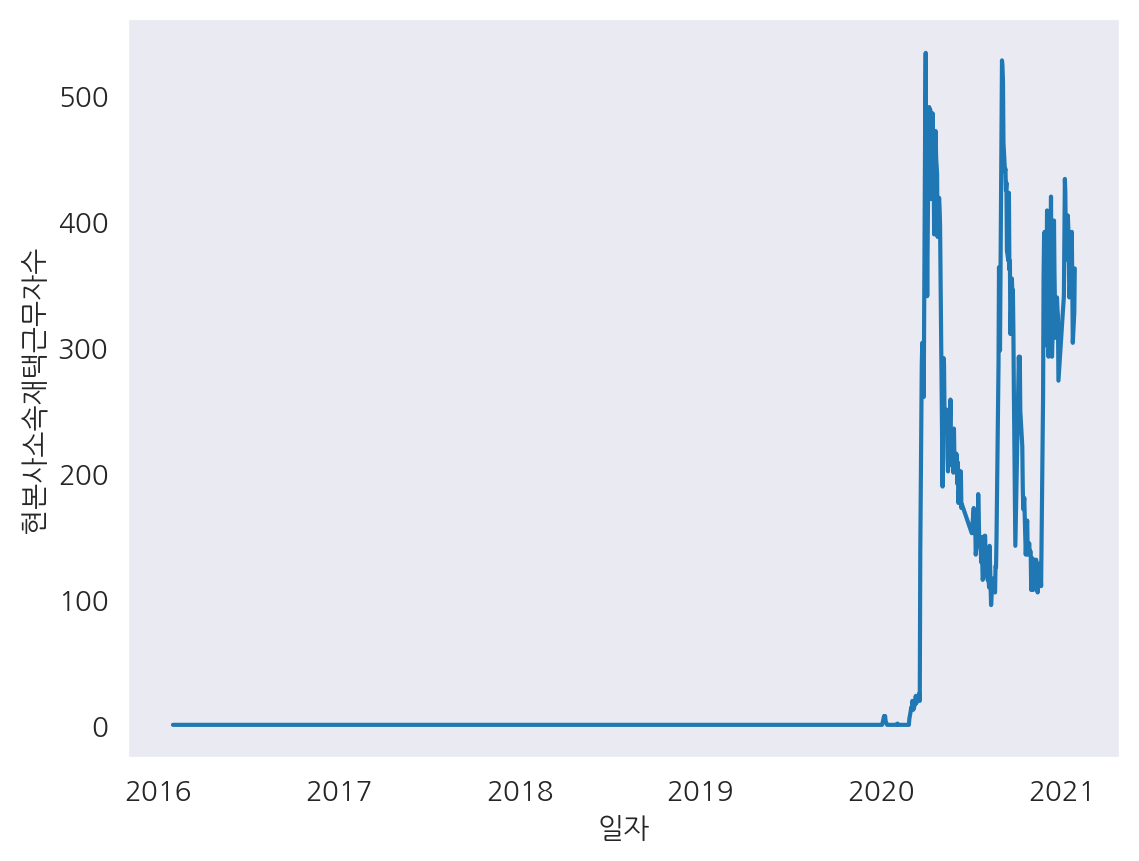

In [232]:
sns.lineplot(train, x = '일자', y = '현본사소속재택근무자수');